<a href="https://colab.research.google.com/github/Zerkclown/Phonetix/blob/main/Phonetix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## High Level Pre-Study Notes and Goals:



1. Split by space (then give a second pass to make sure it is seperate)
2. Identify (and accordingly relabel) consonants precended by a vowel in video/voice
3. multiply the dataset by speeding and slowing down each clip (0.25x, 0.5x, 0.75x, 1x, 1.25x, 1.5x, 1.75x, 2x)
4. Split voice and sound (duing processing)




To Do Notes:

how to identify normalized pace (7arakat el mad) and word stess irrespective of temporal duration/speed (husarry is correct) and inflection

will have to encode (optionally) pauses


# https://towardsdatascience.com/extracting-audio-from-video-using-python-58856a940fd

In [ ]:
! pip install pydub
! pip install moviepy
! pip install imageio==2.4.1
! pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 4.6 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=c5ee49f6dd29fcd527feb11c4d0ac5f964b199af26a84bd107e7b5f4b756ef1d
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=cd9b7e69a7cd600d1104f

#Imports and Globals

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

import IPython.display as ipd
from tqdm.notebook import tqdm

import datetime
from pydub import AudioSegment
from pydub.silence import split_on_silence, detect_nonsilent
from moviepy.video.io.VideoFileClip import VideoFileClip

from google.colab.patches import cv2_imshow # for debugging only

import moviepy.editor as mp
import re

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Helper Functions

In [ ]:
## Helper function for plotting opencv images in notebook
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

In [ ]:
# helper functions for video trimming

def applyTimePad(start, end, pad, max):
  start = (start - pad)/1000
  end = (end + pad)/1000

  startTime, endTime = (0 if start<0 else start, max if end>max else end)
  print(f'start: {start} s:{startTime}; end:{end} e:{endTime} \ max:{max}')
  return (0 if start<0 else start, max if end>max else end)

def splitVideoMoviePy(inputVideoFilePath, outputVideoFilePath, startTime, endTime, silencePad, clipDuaration):
  # source: https://stackoverflow.com/questions/37317140/cutting-out-a-portion-of-video-python
  startTime, endTime = applyTimePad(startTime, endTime, silencePad, clipDuaration)
  VideoFileClip(inputVideoFilePath).subclip(startTime, endTime).write_videofile(outputVideoFilePath, audio_codec='aac')

def splitVideoFFMPEG(inputVideoFilePath, outputVideoFilePath, startTime, endTime, silencePad = 100):
  timeFormatter = lambda time : datetime.datetime.fromtimestamp(time / 1000).strftime('%H:%M:%S.%f')

  cmd = [
      "ffmpeg", 
      "-i", inputVideoFilePath, 
      "-ss", timeFormatter(startTime - silencePad),
      "-to", timeFormatter(endTime + silencePad),
      "-c", "copy",
      outputVideoFilePath
  ]

  print(' '.join(cmd))
  subprocess.run(cmd, shell=True, env=os.environ.copy())
  # subprocess.run(cmd)

  # TODO: fix subprocess!!!! it is not working for me

def splitVideoCV(inputVideoFilePath, outputVideoFilePath, startTime, endTime, silencePad = 100):
  #source: https://github.com/Lantop1k/Video-Croper-OpenCV/blob/main/videocropper.py

  cap = cv2.VideoCapture(inputVideoFilePath) #Read Frame

  fps=cap.get(cv2.CAP_PROP_FPS)    #Extract the frame per second (fps)
  height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #height
  width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) #width

  startFrame = fps * startTime/1000
  endFrame = fps * endTime/1000

  fourcc = cv2.VideoWriter_fourcc(*'h264') #? 0x00000021
  out = cv2.VideoWriter(outputVideoFilePath, fourcc, fps, (width,height))

  counter =1 #set counter
  while(cap.isOpened()):           #while the cap is open

    ret, frame = cap.read()       #read frame
    if frame is None:             #if frame is None
        break  
    
    frame=cv2.resize(frame, (width,height))  #resize the frame
    if counter>= int(startFrame) and counter<= endFrame:  #check for range of output
        print(counter)
        out.write(frame)  #output 

    counter+=1  #increase counter
    
  #release the output and cap  
  out.release()

#Reading in Data

Data is scraped from a an open sourced collection of IPA phonetical sounds pronounced while being visually captured by an MRI machine. The data is part of the Seeing Speech web resource collected collected at the University of Glasgow $^{[1]}$.

**Potential limitations** include biasing the model to the speaker's unique annunciations. Moreover, it should not scale to cases where dental or mouth medical accessories (or mouth deformaties) are introduced.

<br>

---


[1] Lawson, E., Stuart-Smith, J., Scobbie, J. M., Nakai, S. (2018). Seeing Speech: an articulatory web resource for the study of Phonetics. University of Glasgow. 28th April 2022. https://www.seeingspeech.ac.uk/

#### Reading Data Sound Types

In [ ]:
dataPaths = {
    'vowels': '/content/drive/MyDrive/IPA_Dataset/vowels',
    'pulmonicConsonants': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic',
    'nonPulmonicConsonants': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic',
    'otherSymbols': '/content/drive/MyDrive/IPA_Dataset/other_symbols',
}

vowelSounds = [f for f in os.listdir(dataPaths['vowels']) if not os.path.isfile(os.path.join(dataPaths['vowels'], f))]
pulmonicConsonantSounds = [f for f in os.listdir(dataPaths['pulmonicConsonants']) if not os.path.isfile(os.path.join(dataPaths['pulmonicConsonants'], f))]
nonPulmonicConsonantSounds = [f for f in os.listdir(dataPaths['nonPulmonicConsonants']) if not os.path.isfile(os.path.join(dataPaths['nonPulmonicConsonants'], f))]
otherSymbolSounds = [f for f in os.listdir(dataPaths['otherSymbols']) if not os.path.isfile(os.path.join(dataPaths['otherSymbols'], f))]

In [ ]:
print(vowelSounds)
print(pulmonicConsonantSounds)
print(nonPulmonicConsonantSounds)
print(otherSymbolSounds)

['ø', 'a', 'œ', 'i', 'y', 'e', 'o', 'u', 'ɔ', 'ə', 'ɛ', 'ɯ', 'ɪ', 'ɶ', 'ɨ', 'ʉ', 'ɒ', 'ɤ', 'ʊ', 'ʌ', 'ɑ']
['m', 'f', 'c', 'j', 'k', 'b', 'l', 'd', 'h', 'n', 'p', 'q', 't', 'ð', 'z', 'v', 'r', 'x', 'ħ', 'ç', 's', 'ŋ', 'ɖ', 'ɣ', 'ɲ', 'ɬ', 'ɡ', 'ɢ', 'ʀ', 'ɟ', 'ʒ', 'ɦ', 'ʃ', 'ʋ', 'ʈ', 'ɭ', 'ɮ', 'ɰ', 'ɳ', 'ɾ', 'ʁ', 'ɻ', 'ʎ', 'ʂ', 'ɹ', 'ɸ', 'ɴ', 'ʐ', 'ʔ', 'ʕ', 'ɽ', 'ʝ', 'ʙ', 'ⱱ', 'ʟ', 'χ', 'θ', 'ɱ', 'β']
['kʼ', 'pʼ', 'ǁ', 'ǂ', 'sʼ', 'ɠ', 'ɓ', 'ǀ', 'ɗ', 'ǃ', 'tʼ', 'ʄ', 'ʘ', 'ʛ']
['ʑ', 'ɥ', 'ɧ', 'ɕ', 'w', 'ɺ', 'ʍ', 'ʜ', 'ʡ', 'ʢ']


#### Storing Data File Loaction

In [ ]:
rootPath = '/content/drive/MyDrive/IPA_Dataset/'

soundFilesWhole = []

for path, subdirs, files in os.walk(rootPath):
    for name in files:
      if not subdirs:
        soundFilesWhole.append ({'path': path, 
                            'soundLabel': path.replace(rootPath, ''),
                            'videoFile': files[0],
        })
                            # 'audioFile': files[1]})

In [ ]:
print(len(soundFilesWhole)) # 104 sound types # 106 sounds # 208 sounds !Why is it increasing?

104


#Visualizing Data

#### Watching a Random Sound Clip

In [ ]:
from random import sample

randSoundSampleData = sample(soundFilesWhole, 1)[0]

print(randSoundSampleData)
ipd.Video(os.path.join(randSoundSampleData['path'], randSoundSampleData['videoFile']), embed=True, width = 400)

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ǂ', 'soundLabel': 'consonants/nonPulmonic/ǂ', 'videoFile': 'MRI_palato-alveolar_click.mp4'}


#### Reading Metadata

In [ ]:
#capture video
sampleVidCapture = cv2.VideoCapture(os.path.join(randSoundSampleData['path'], randSoundSampleData['videoFile']))
print('CAP_PROP_FRAME_COUNT: ', sampleVidCapture.get(cv2.CAP_PROP_FRAME_COUNT))
print('CAP_PROP_FPS: ', sampleVidCapture.get(cv2.CAP_PROP_FPS))
print('CAP_PROP_FRAME_HEIGHT: ', sampleVidCapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('CAP_PROP_FRAME_WIDTH: ', sampleVidCapture.get(cv2.CAP_PROP_FRAME_WIDTH))

CAP_PROP_FRAME_COUNT:  52.0
CAP_PROP_FPS:  7.0
CAP_PROP_FRAME_HEIGHT:  86.0
CAP_PROP_FRAME_WIDTH:  90.0


In [ ]:
# get one frame
ret, img = sampleVidCapture.read()
print(ret, img.shape)

True (86, 90, 3)


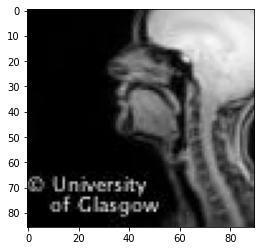

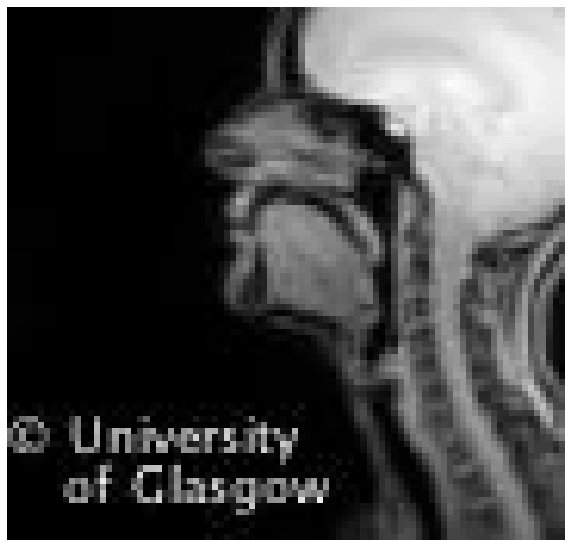

In [ ]:
# display captured frame
plt.imshow(img)
display_cv2_img(img)

In [ ]:
# release video
sampleVidCapture.release()

#### Display Video as Frames

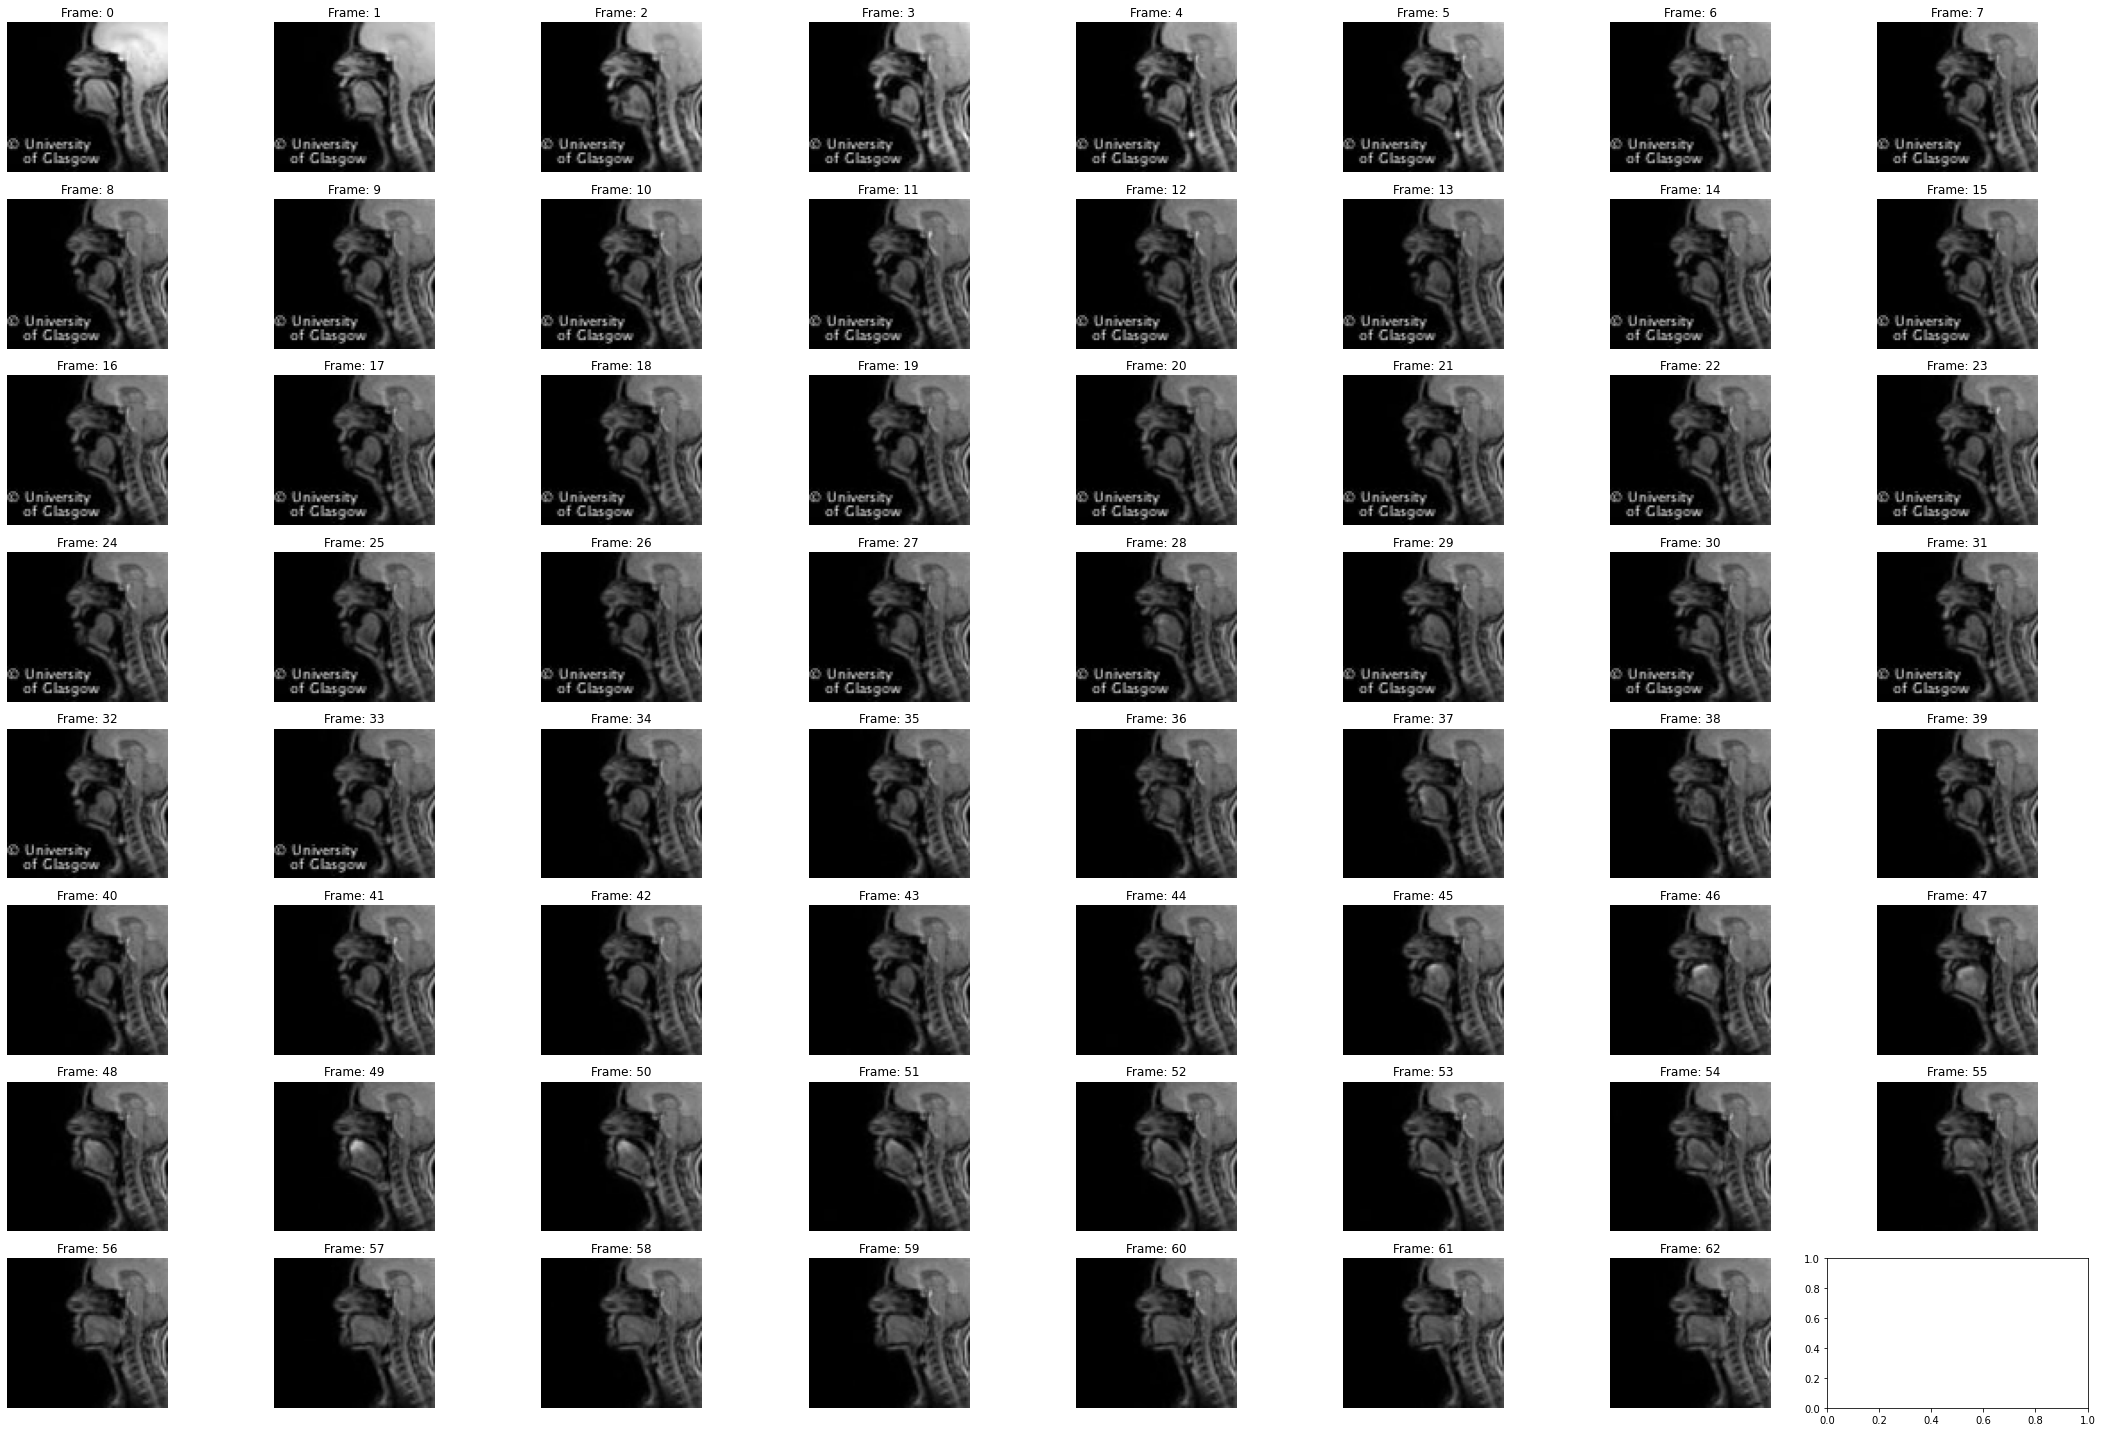

In [ ]:
from math import ceil

randSoundSampleData = sample(soundFilesWhole, 1)[0]
sampleVidCapture = cv2.VideoCapture(os.path.join(randSoundSampleData['path'], randSoundSampleData['videoFile']))
n_frames = int(sampleVidCapture.get(cv2.CAP_PROP_FRAME_COUNT))

fig, axs = plt.subplots(ceil(n_frames**0.5), ceil(n_frames**0.5), figsize=(30, 20))
axs = axs.flatten()

img_idx = 0
for frame in range(n_frames):
    ret, img = sampleVidCapture.read()
    if ret == False:
        break
    axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[img_idx].set_title(f'Frame: {frame}')
    axs[img_idx].axis('off')
    img_idx += 1

plt.tight_layout()
plt.show()
sampleVidCapture.release()

#Augmenting Sound Clips

####Cropping Exess Pixels (Including Watermark)

In [ ]:
#ref https://stackoverflow.com/questions/57354527/cropping-video-with-opencv-in-python-mac

for soundFile in soundFilesWhole:
  inputPath = os.path.join(soundFile['path'], soundFile['videoFile'])
  cap = cv2.VideoCapture(inputPath)

  ret, frame = cap.read()
  height, width = frame.shape[:2]

  outputVideoFilePath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
  outputPath = os.path.join(outputVideoFilePath, soundFile['videoFile'])
  
  fourcc = cv2.VideoWriter_fourcc(*'MP4v')
  fps=cap.get(cv2.CAP_PROP_FPS)    #Extract the frame per second (fps)
  outVideo = cv2.VideoWriter(outputPath, fourcc, fps, (width - 25, int(height*.75)))

  while ret:
    # if frame is None:
    #   outVideo.release()
    #   break

    croppedFrame = frame[0:int(height*.75), 25:width]
    outVideo.write(croppedFrame)  # ! not saving <not related to overwriting>


    ret, frame = cap.read()
  
  outVideo.release()


#### Extracting Audio from all video files

In [ ]:
for soundFile in soundFilesWhole:
  clip = mp.VideoFileClip(os.path.join(soundFile['path'], soundFile['videoFile']), audio=True)
  audioFilePath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
  audioFileName = re.sub(r'\..*', '.mp3', soundFile['videoFile'])
  soundFile['audioFile'] = audioFileName
  clip.audio.write_audiofile(os.path.join(audioFilePath, audioFileName))

path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative.mp3


100%|██████████| 178/178 [00:00<00:00, 789.81it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant.mp3


100%|██████████| 164/164 [00:00<00:00, 750.95it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative.mp3


100%|██████████| 180/180 [00:00<00:00, 841.45it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative.mp3


100%|██████████| 201/201 [00:00<00:00, 861.22it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant.mp3


100%|██████████| 100/100 [00:00<00:00, 743.16it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap.mp3


100%|██████████| 149/149 [00:00<00:00, 815.83it/s]


[MoviePy] Done.
path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative.mp3


100%|██████████| 142/142 [00:00<00:00, 826.63it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative.mp3


100%|██████████| 92/92 [00:00<00:00, 640.81it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive.mp3


100%|██████████| 110/110 [00:00<00:00, 279.23it/s]


[MoviePy] Done.
path:  /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʢ/MRI_vd_epiglottal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʢ/MRI_vd_epiglottal_fricative.mp3


100%|██████████| 76/76 [00:00<00:00, 114.12it/s]


[MoviePy] Done.
path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 278.90it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 256.87it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 841.27it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 857.24it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 848.09it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 791.50it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 823.89it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 821.13it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 774.87it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel.mp3


100%|██████████| 199/199 [00:00<00:00, 856.25it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 800.71it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 823.19it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 844.18it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 858.79it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new.mp3


100%|██████████| 205/205 [00:00<00:00, 873.78it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new.mp3


100%|██████████| 205/205 [00:00<00:00, 766.35it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 847.46it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 773.49it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 840.13it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 842.97it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel.mp3


100%|██████████| 201/201 [00:00<00:00, 856.02it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal.mp3


100%|██████████| 245/245 [00:00<00:00, 884.55it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative.mp3


100%|██████████| 222/222 [00:00<00:00, 863.21it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive.mp3


100%|██████████| 183/183 [00:00<00:00, 856.94it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant.mp3


100%|██████████| 177/177 [00:00<00:00, 793.46it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive.mp3


100%|██████████| 112/112 [00:00<00:00, 653.94it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive.mp3


100%|██████████| 222/222 [00:00<00:00, 842.79it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant.mp3


100%|██████████| 199/199 [00:00<00:00, 834.31it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive.mp3


100%|██████████| 174/174 [00:00<00:00, 739.90it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative.mp3


100%|██████████| 142/142 [00:00<00:00, 774.43it/s]


[MoviePy] Done.
path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal.mp3


100%|██████████| 221/221 [00:00<00:00, 803.59it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive.mp3


100%|██████████| 201/201 [00:00<00:00, 779.59it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive.mp3


100%|██████████| 104/104 [00:00<00:00, 708.70it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive.mp3


100%|██████████| 164/164 [00:00<00:00, 817.09it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative.mp3


100%|██████████| 178/178 [00:00<00:00, 740.96it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative.mp3


100%|██████████| 193/193 [00:00<00:00, 468.53it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative.mp3


100%|██████████| 222/222 [00:00<00:00, 326.40it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill.mp3


100%|██████████| 201/201 [00:00<00:00, 765.38it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative.mp3


100%|██████████| 154/154 [00:00<00:00, 779.13it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ħ/MRI_vl_pharyngeal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ħ/MRI_vl_pharyngeal_fricative.mp3


100%|██████████| 137/137 [00:00<00:00, 739.68it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative.mp3


100%|██████████| 201/201 [00:00<00:00, 782.74it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative.mp3


100%|██████████| 201/201 [00:00<00:00, 833.79it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal.mp3


100%|██████████| 142/142 [00:00<00:00, 741.16it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive.mp3


100%|██████████| 183/183 [00:00<00:00, 733.40it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative.mp3


100%|██████████| 131/131 [00:00<00:00, 725.49it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal.mp3


100%|██████████| 178/178 [00:00<00:00, 824.00it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative.mp3


100%|██████████| 222/222 [00:00<00:00, 695.67it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive.mp3


100%|██████████| 95/95 [00:00<00:00, 671.85it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive.mp3


100%|██████████| 100/100 [00:00<00:00, 653.65it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill.mp3


100%|██████████| 174/174 [00:00<00:00, 807.62it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive.mp3


100%|██████████| 149/149 [00:00<00:00, 774.95it/s]


[MoviePy] Done.
path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative.mp3


100%|██████████| 201/201 [00:00<00:00, 818.86it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative.mp3


100%|██████████| 144/144 [00:00<00:00, 764.98it/s]


[MoviePy] Done.
path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative.mp3


100%|██████████| 201/201 [00:00<00:00, 850.38it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant.mp3


100%|██████████| 201/201 [00:00<00:00, 803.04it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive.mp3


100%|██████████| 201/201 [00:00<00:00, 774.06it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant.mp3


100%|██████████| 201/201 [00:00<00:00, 815.90it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative.mp3


100%|██████████| 178/178 [00:00<00:00, 754.86it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant.mp3


100%|██████████| 98/98 [00:00<00:00, 666.79it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal.mp3


100%|██████████| 221/221 [00:00<00:00, 874.06it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap.mp3


100%|██████████| 145/145 [00:00<00:00, 724.67it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative.mp3


100%|██████████| 131/131 [00:00<00:00, 732.46it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant.mp3


100%|██████████| 201/201 [00:00<00:00, 827.84it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant.mp3


100%|██████████| 201/201 [00:00<00:00, 795.70it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative.mp3


100%|██████████| 201/201 [00:00<00:00, 802.06it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant.mp3


100%|██████████| 158/158 [00:00<00:00, 761.51it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative.mp3


100%|██████████| 222/222 [00:00<00:00, 871.10it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal.mp3


100%|██████████| 125/125 [00:00<00:00, 726.72it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative.mp3


100%|██████████| 178/178 [00:00<00:00, 768.21it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive.mp3


100%|██████████| 167/167 [00:00<00:00, 843.50it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative.mp3


100%|██████████| 155/155 [00:00<00:00, 788.85it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap.mp3


100%|██████████| 178/178 [00:00<00:00, 759.98it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative.mp3


100%|██████████| 178/178 [00:00<00:00, 821.49it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill.mp3


100%|██████████| 112/112 [00:00<00:00, 712.68it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap.mp3


100%|██████████| 178/178 [00:00<00:00, 762.79it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant.mp3


100%|██████████| 167/167 [00:00<00:00, 785.34it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative.mp3


100%|██████████| 177/177 [00:00<00:00, 826.67it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative.mp3


100%|██████████| 222/222 [00:00<00:00, 847.67it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal.mp3


100%|██████████| 317/317 [00:00<00:00, 903.66it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative.mp3


100%|██████████| 178/178 [00:00<00:00, 811.32it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective.mp3


100%|██████████| 133/133 [00:00<00:00, 361.13it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective.mp3


100%|██████████| 164/164 [00:00<00:00, 340.72it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click.mp3


100%|██████████| 177/177 [00:00<00:00, 388.83it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click.mp3


100%|██████████| 164/164 [00:00<00:00, 378.44it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective.mp3


100%|██████████| 174/174 [00:00<00:00, 434.05it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive.mp3


100%|██████████| 102/102 [00:00<00:00, 308.11it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive.mp3


100%|██████████| 142/142 [00:00<00:00, 367.30it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click.mp3


100%|██████████| 177/177 [00:00<00:00, 414.85it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive.mp3


100%|██████████| 149/149 [00:00<00:00, 321.01it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click.mp3


100%|██████████| 174/174 [00:00<00:00, 423.05it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective.mp3


100%|██████████| 177/177 [00:00<00:00, 382.29it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive.mp3


100%|██████████| 136/136 [00:00<00:00, 298.60it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click.mp3


100%|██████████| 180/180 [00:00<00:00, 433.35it/s]

[MoviePy] Done.


path:  /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive.mp3
[MoviePy] Writing audio in /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive.mp3


100%|██████████| 106/106 [00:00<00:00, 302.57it/s]

[MoviePy] Done.


####Identifying Acustic Pauses and Spliting Recordings

In [ ]:
timePad = 550 # 0.55 second of padding (empirically found)

for soundFile in soundFilesWhole:
  print(soundFile)
  inputAudioFilePath = os.path.join(soundFile['path'], soundFile['audioFile'])
  outputAudioFileDirPath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
  
  
  inputAudioFilePath = os.path.join(outputAudioFileDirPath, soundFile['audioFile']) # reading audio only from the destination file

  # reading from audio mp3 file
  sound = AudioSegment.from_mp3(inputAudioFilePath) 
  # spliting audio files
  audioChunks = split_on_silence(sound, min_silence_len=500, silence_thresh=-40, keep_silence = timePad)
  timeStamps = detect_nonsilent(sound, min_silence_len=500, silence_thresh=-40)
  audioDuration = sound.duration_seconds

  #loop is used to iterate over the output list
  for i, chunk in enumerate(audioChunks):
    audioChunkName = re.sub(r'(\..*)', f'{i}' + r'\1', soundFile['audioFile'])
    outputFilePath = os.path.join(outputAudioFileDirPath, audioChunkName)
    chunk.export(outputFilePath, format="mp3")

    inputVideoFilePath = os.path.join(soundFile['path'], soundFile['videoFile'])

  # splitting video files
  for i, (startTime, endTime) in enumerate(timeStamps):
    videoFilePath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
    videoFileName = re.sub(r'(\..*)', f'{i}' + r'\1', soundFile['videoFile'])
    outputVideoFilePath = os.path.join(videoFilePath, videoFileName)

    print(f'outputVideoFilePath: {outputVideoFilePath}')


    inputVideoFilePath = os.path.join(videoFilePath, soundFile['videoFile']) # reading video only from the destination file

    print('Duaration: ', audioDuration)

    # spliting video into chunks
    splitVideoMoviePy(inputVideoFilePath, outputVideoFilePath, startTime, endTime, timePad, audioDuration)

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ʑ', 'soundLabel': 'other_symbols/ʑ', 'videoFile': 'MRI_vd_alveolo-palatal_fricative.mp4', 'audioFile': 'MRI_vd_alveolo-palatal_fricative.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative0.mp4
Duaration:  8.039977324263038
start: 0.121 s:0.121; end:1.767 e:1.767 \ max:8.039977324263038
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative0.mp4


100%|██████████| 12/12 [00:00<00:00, 240.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative1.mp4
Duaration:  8.039977324263038
start: 1.515 s:1.515; end:3.595 e:3.595 \ max:8.039977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 251.53it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative2.mp4
Duaration:  8.039977324263038
start: 3.237 s:3.237; end:5.363 e:5.363 \ max:8.039977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 239.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative3.mp4
Duaration:  8.039977324263038
start: 5.136 s:5.136; end:7.149 e:7.149 \ max:8.039977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative3.mp4


100%|██████████| 15/15 [00:00<00:00, 236.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʑ/MRI_vd_alveolo-palatal_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ɥ', 'soundLabel': 'other_symbols/ɥ', 'videoFile': 'MRI_vd_labial-palatal_approximant.mp4', 'audioFile': 'MRI_vd_labial-palatal_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant0.mp4
Duaration:  7.43
start: -0.004 s:0; end:1.582 e:1.582 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant0.mp4


100%|██████████| 12/12 [00:00<00:00, 183.83it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant1.mp4
Duaration:  7.43
start: 1.122 s:1.122; end:3.202 e:3.202 \ max:7.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant1.mp4


100%|██████████| 15/15 [00:00<00:00, 233.12it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant2.mp4
Duaration:  7.43
start: 2.942 s:2.942; end:5.027 e:5.027 \ max:7.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant2.mp4


100%|██████████| 15/15 [00:00<00:00, 250.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant3.mp4
Duaration:  7.43
start: 4.774 s:4.774; end:6.806 e:6.806 \ max:7.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant3.mp4


100%|██████████| 15/15 [00:00<00:00, 244.53it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɥ/MRI_vd_labial-palatal_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ɧ', 'soundLabel': 'other_symbols/ɧ', 'videoFile': 'MRI_vl_postalveolar-velar_fricative.mp4', 'audioFile': 'MRI_vl_postalveolar-velar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative0.mp4
Duaration:  8.14
start: 0.407 s:0.407; end:1.855 e:1.855 \ max:8.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 176.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative1.mp4
Duaration:  8.14
start: 2.374 s:2.374; end:4.538 e:4.538 \ max:8.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 240.19it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative2.mp4
Duaration:  8.14
start: 4.766 s:4.766; end:7.008 e:7.008 \ max:8.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 210.38it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɧ/MRI_vl_postalveolar-velar_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ɕ', 'soundLabel': 'other_symbols/ɕ', 'videoFile': 'MRI_vl_alveolo-palatal_fricative.mp4', 'audioFile': 'MRI_vl_alveolo-palatal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative0.mp4
Duaration:  9.1
start: 0.255 s:0.255; end:1.646 e:1.646 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 162.75it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative1.mp4
Duaration:  9.1
start: 1.518 s:1.518; end:3.77 e:3.77 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 239.25it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative2.mp4
Duaration:  9.1
start: 3.601 s:3.601; end:6.007 e:6.007 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative2.mp4


100%|██████████| 17/17 [00:00<00:00, 261.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative3.mp4
Duaration:  9.1
start: 5.791 s:5.791; end:8.157 e:8.157 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative3.mp4


100%|██████████| 17/17 [00:00<00:00, 240.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɕ/MRI_vl_alveolo-palatal_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/w', 'soundLabel': 'other_symbols/w', 'videoFile': 'MRI_vd_labial-velar_approximant.mp4', 'audioFile': 'MRI_vd_labial-velar_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant0.mp4
Duaration:  4.53
start: 0.157 s:0.157; end:1.81 e:1.81 \ max:4.53
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant0.mp4


100%|██████████| 12/12 [00:00<00:00, 177.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant1.mp4
Duaration:  4.53
start: 1.368 s:1.368; end:3.497 e:3.497 \ max:4.53


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant1.mp4


100%|██████████| 15/15 [00:00<00:00, 213.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/w/MRI_vd_labial-velar_approximant1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ɺ', 'soundLabel': 'other_symbols/ɺ', 'videoFile': 'MRI_vd_alveolar-lateral_flap.mp4', 'audioFile': 'MRI_vd_alveolar-lateral_flap.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap0.mp4
Duaration:  6.72
start: 0.361 s:0.361; end:2.244 e:2.244 \ max:6.72
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap0.mp4


100%|██████████| 14/14 [00:00<00:00, 215.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap1.mp4
Duaration:  6.72
start: 1.868 s:1.868; end:3.647 e:3.647 \ max:6.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap1.mp4


100%|██████████| 13/13 [00:00<00:00, 169.38it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap2.mp4
Duaration:  6.72
start: 3.416 s:3.416; end:5.188 e:5.188 \ max:6.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap2.mp4


100%|██████████| 13/13 [00:00<00:00, 202.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ɺ/MRI_vd_alveolar-lateral_flap2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ʍ', 'soundLabel': 'other_symbols/ʍ', 'videoFile': 'MRI_vl_labial-velar_fricative.mp4', 'audioFile': 'MRI_vl_labial-velar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative0.mp4
Duaration:  6.43
start: 1.489 s:1.489; end:3.494 e:3.494 \ max:6.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative0.mp4


100%|██████████| 15/15 [00:00<00:00, 267.77it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative1.mp4
Duaration:  6.43
start: 3.494 s:3.494; end:5.626 e:5.626 \ max:6.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 174.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʍ/MRI_vl_labial-velar_fricative1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ʜ', 'soundLabel': 'other_symbols/ʜ', 'videoFile': 'MRI_vl_epiglottal_fricative.mp4', 'audioFile': 'MRI_vl_epiglottal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative0.mp4
Duaration:  4.14
start: 0.125 s:0.125; end:1.434 e:1.434 \ max:4.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 154.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative1.mp4
Duaration:  4.14
start: 1.334 s:1.334; end:3.617 e:3.617 \ max:4.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 244.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ʡ', 'soundLabel': 'other_symbols/ʡ', 'videoFile': 'MRI_vl_epiglottal_plosive.mp4', 'audioFile': 'MRI_vl_epiglottal_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive0.mp4
Duaration:  4.96
start: 0.198 s:0.198; end:2.48 e:2.48 \ max:4.96
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive0.mp4


100%|██████████| 16/16 [00:00<00:00, 247.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive1.mp4
Duaration:  4.96
start: 2.192 s:2.192; end:4.292 e:4.292 \ max:4.96


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive1.mp4


100%|██████████| 15/15 [00:00<00:00, 77.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʡ/MRI_vl_epiglottal_plosive1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/other_symbols/ʢ', 'soundLabel': 'other_symbols/ʢ', 'videoFile': 'MRI_vd_epiglottal_fricative.mp4', 'audioFile': 'MRI_vd_epiglottal_fricative.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʢ/MRI_vd_epiglottal_fricative0.mp4
Duaration:  3.41
start: 0.043 s:0.043; end:2.975 e:2.975 \ max:3.41
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʢ/MRI_vd_epiglottal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʢ/MRI_vd_epiglottal_fricative0.mp4


100%|██████████| 21/21 [00:00<00:00, 328.05it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʢ/MRI_vd_epiglottal_fricative0.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ø', 'soundLabel': 'vowels/ø', 'videoFile': 'MRI_cardinal_10_vowel.mp4', 'audioFile': 'MRI_cardinal_10_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel0.mp4
Duaration:  9.1
start: 0.346 s:0.346; end:2.031 e:2.031 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 189.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel1.mp4
Duaration:  9.1
start: 2.096 s:2.096; end:4.46 e:4.46 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 269.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel2.mp4
Duaration:  9.1
start: 4.666 s:4.666; end:7.009 e:7.009 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 245.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ø/MRI_cardinal_10_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/a', 'soundLabel': 'vowels/a', 'videoFile': 'MRI_cardinal_4_vowel.mp4', 'audioFile': 'MRI_cardinal_4_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel0.mp4
Duaration:  9.1
start: 0.534 s:0.534; end:2.186 e:2.186 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 205.39it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel1.mp4
Duaration:  9.1
start: 1.984 s:1.984; end:4.232 e:4.232 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel1.mp4


100%|██████████| 16/16 [00:00<00:00, 236.13it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel2.mp4
Duaration:  9.1
start: 4.367 s:4.367; end:6.672 e:6.672 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 277.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/a/MRI_cardinal_4_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/œ', 'soundLabel': 'vowels/œ', 'videoFile': 'MRI_cardinal_11_vowel.mp4', 'audioFile': 'MRI_cardinal_11_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel0.mp4
Duaration:  9.1
start: 0.392 s:0.392; end:2.072 e:2.072 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 131.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel1.mp4
Duaration:  9.1
start: 1.841 s:1.841; end:4.204 e:4.204 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 178.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel1.mp4 



outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel2.mp4
Duaration:  9.1
start: 4.384 s:4.384; end:6.785 e:6.785 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 180.33it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/œ/MRI_cardinal_11_vowel2.mp4 



{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/i', 'soundLabel': 'vowels/i', 'videoFile': 'MRI_cardinal_1_vowel.mp4', 'audioFile': 'MRI_cardinal_1_vowel.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel0.mp4
Duaration:  9.1
start: 0.41 s:0.41; end:2.104 e:2.104 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 199.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel1.mp4
Duaration:  9.1
start: 2.208 s:2.208; end:4.457 e:4.457 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel1.mp4


100%|██████████| 16/16 [00:00<00:00, 248.63it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel2.mp4
Duaration:  9.1
start: 4.768 s:4.768; end:6.993 e:6.993 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel2.mp4


100%|██████████| 16/16 [00:00<00:00, 252.38it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/i/MRI_cardinal_1_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/y', 'soundLabel': 'vowels/y', 'videoFile': 'MRI_cardinal_9_vowel.mp4', 'audioFile': 'MRI_cardinal_9_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel0.mp4
Duaration:  9.1
start: 0.54 s:0.54; end:2.385 e:2.385 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel0.mp4


100%|██████████| 13/13 [00:00<00:00, 191.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel1.mp4
Duaration:  9.1
start: 2.36 s:2.36; end:4.798 e:4.798 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel1.mp4


100%|██████████| 18/18 [00:00<00:00, 274.83it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel2.mp4
Duaration:  9.1
start: 4.863 s:4.863; end:7.187 e:7.187 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 241.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/y/MRI_cardinal_9_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/e', 'soundLabel': 'vowels/e', 'videoFile': 'MRI_cardinal_2_vowel.mp4', 'audioFile': 'MRI_cardinal_2_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel0.mp4
Duaration:  9.1
start: 0.539 s:0.539; end:2.25 e:2.25 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 190.87it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel1.mp4
Duaration:  9.1
start: 2.24 s:2.24; end:4.578 e:4.578 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 255.06it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel2.mp4
Duaration:  9.1
start: 4.762 s:4.762; end:7.152 e:7.152 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 252.19it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/e/MRI_cardinal_2_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/o', 'soundLabel': 'vowels/o', 'videoFile': 'MRI_cardinal_7_vowel.mp4', 'audioFile': 'MRI_cardinal_7_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel0.mp4
Duaration:  9.1
start: 0.267 s:0.267; end:1.982 e:1.982 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel0.mp4


100%|██████████| 13/13 [00:00<00:00, 211.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel1.mp4
Duaration:  9.1
start: 1.81 s:1.81; end:4.136 e:4.136 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 285.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel2.mp4
Duaration:  9.1
start: 4.221 s:4.221; end:6.514 e:6.514 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 263.93it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/o/MRI_cardinal_7_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/u', 'soundLabel': 'vowels/u', 'videoFile': 'MRI_cardinal_8_vowel.mp4', 'audioFile': 'MRI_cardinal_8_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel0.mp4
Duaration:  9.1
start: 0.207 s:0.207; end:2.047 e:2.047 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel0.mp4


100%|██████████| 13/13 [00:00<00:00, 234.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel1.mp4
Duaration:  9.1
start: 1.727 s:1.727; end:4.155 e:4.155 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 316.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel2.mp4
Duaration:  9.1
start: 4.02 s:4.02; end:6.46 e:6.46 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel2.mp4


100%|██████████| 18/18 [00:00<00:00, 273.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/u/MRI_cardinal_8_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɔ', 'soundLabel': 'vowels/ɔ', 'videoFile': 'MRI_cardinal_6_vowel.mp4', 'audioFile': 'MRI_cardinal_6_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel0.mp4
Duaration:  9.1
start: 0.348 s:0.348; end:2.091 e:2.091 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel0.mp4


100%|██████████| 13/13 [00:00<00:00, 203.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel1.mp4
Duaration:  9.1
start: 1.947 s:1.947; end:4.281 e:4.281 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 256.41it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel2.mp4
Duaration:  9.1
start: 4.559 s:4.559; end:6.888 e:6.888 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 246.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɔ/MRI_cardinal_6_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ə', 'soundLabel': 'vowels/ə', 'videoFile': 'MRI_central_schwa_float_vowel.mp4', 'audioFile': 'MRI_central_schwa_float_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel0.mp4
Duaration:  9.0
start: 0.241 s:0.241; end:1.946 e:1.946 \ max:9.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 185.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel1.mp4
Duaration:  9.0
start: 1.523 s:1.523; end:3.814 e:3.814 \ max:9.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 314.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel2.mp4
Duaration:  9.0
start: 3.929 s:3.929; end:6.209 e:6.209 \ max:9.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel2.mp4


100%|██████████| 16/16 [00:00<00:00, 250.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ə/MRI_central_schwa_float_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɛ', 'soundLabel': 'vowels/ɛ', 'videoFile': 'MRI_cardinal_3_vowel.mp4', 'audioFile': 'MRI_cardinal_3_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel0.mp4
Duaration:  9.1
start: 0.624 s:0.624; end:2.141 e:2.141 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel0.mp4


100%|██████████| 11/11 [00:00<00:00, 176.41it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel1.mp4
Duaration:  9.1
start: 2.11 s:2.11; end:4.387 e:4.387 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel1.mp4


100%|██████████| 16/16 [00:00<00:00, 249.64it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel2.mp4
Duaration:  9.1
start: 4.872 s:4.872; end:7.128 e:7.128 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel2.mp4


100%|██████████| 16/16 [00:00<00:00, 244.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɛ/MRI_cardinal_3_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɯ', 'soundLabel': 'vowels/ɯ', 'videoFile': 'MRI_cardinal_16_vowel.mp4', 'audioFile': 'MRI_cardinal_16_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel0.mp4
Duaration:  9.1
start: 0.135 s:0.135; end:1.879 e:1.879 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel0.mp4


100%|██████████| 13/13 [00:00<00:00, 241.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel1.mp4
Duaration:  9.1
start: 1.69 s:1.69; end:4.115 e:4.115 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 770.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel2.mp4
Duaration:  9.1
start: 4.122 s:4.122; end:6.552 e:6.552 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel2.mp4


100%|██████████| 18/18 [00:00<00:00, 262.70it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɯ/MRI_cardinal_16_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɪ', 'soundLabel': 'vowels/ɪ', 'videoFile': 'MRI_front_close_float_vowel.mp4', 'audioFile': 'MRI_front_close_float_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel0.mp4
Duaration:  9.1
start: 0.326 s:0.326; end:1.98 e:1.98 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 189.73it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel1.mp4
Duaration:  9.1
start: 1.789 s:1.789; end:3.928 e:3.928 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel1.mp4


100%|██████████| 15/15 [00:00<00:00, 239.97it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel2.mp4
Duaration:  9.1
start: 4.173 s:4.173; end:6.454 e:6.454 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel2.mp4


100%|██████████| 16/16 [00:00<00:00, 253.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɪ/MRI_front_close_float_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɶ', 'soundLabel': 'vowels/ɶ', 'videoFile': 'MRI_cardinal_12_vowel.mp4', 'audioFile': 'MRI_cardinal_12_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel0.mp4
Duaration:  9.1
start: 0.339 s:0.339; end:1.963 e:1.963 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 180.41it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel1.mp4
Duaration:  9.1
start: 1.678 s:1.678; end:3.988 e:3.988 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 249.31it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel2.mp4
Duaration:  9.1
start: 4.151 s:4.151; end:6.55 e:6.55 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 240.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɶ/MRI_cardinal_12_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɨ', 'soundLabel': 'vowels/ɨ', 'videoFile': 'MRI6-58_03_cls_cnt_new.mp4', 'audioFile': 'MRI6-58_03_cls_cnt_new.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new0.mp4
Duaration:  9.289977324263038
start: 0.664 s:0.664; end:2.399 e:2.399 \ max:9.289977324263038
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new0.mp4


100%|██████████| 13/13 [00:00<00:00, 197.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new1.mp4
Duaration:  9.289977324263038
start: 2.679 s:2.679; end:4.986 e:4.986 \ max:9.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new1.mp4


100%|██████████| 17/17 [00:00<00:00, 304.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new2.mp4
Duaration:  9.289977324263038
start: 5.592 s:5.592; end:7.885 e:7.885 \ max:9.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new2.mp4


100%|██████████| 17/17 [00:00<00:00, 259.82it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɨ/MRI6-58_03_cls_cnt_new2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ʉ', 'soundLabel': 'vowels/ʉ', 'videoFile': 'MRI6-58_06_cls_cnt_rnd_new.mp4', 'audioFile': 'MRI6-58_06_cls_cnt_rnd_new.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new0.mp4
Duaration:  9.289977324263038
start: 0.595 s:0.595; end:2.455 e:2.455 \ max:9.289977324263038
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new0.mp4


100%|██████████| 14/14 [00:00<00:00, 183.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new1.mp4
Duaration:  9.289977324263038
start: 2.899 s:2.899; end:5.171 e:5.171 \ max:9.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new1.mp4


100%|██████████| 16/16 [00:00<00:00, 269.19it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new2.mp4
Duaration:  9.289977324263038
start: 5.893 s:5.893; end:8.253 e:8.253 \ max:9.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new2.mp4


100%|██████████| 17/17 [00:00<00:00, 265.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʉ/MRI6-58_06_cls_cnt_rnd_new2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɒ', 'soundLabel': 'vowels/ɒ', 'videoFile': 'MRI_cardinal_13_vowel.mp4', 'audioFile': 'MRI_cardinal_13_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel0.mp4
Duaration:  9.1
start: 0.349 s:0.349; end:1.96 e:1.96 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 183.11it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel1.mp4
Duaration:  9.1
start: 1.821 s:1.821; end:4.08 e:4.08 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel1.mp4


100%|██████████| 16/16 [00:00<00:00, 255.73it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel2.mp4
Duaration:  9.1
start: 4.299 s:4.299; end:6.538 e:6.538 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel2.mp4


100%|██████████| 16/16 [00:00<00:00, 252.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɒ/MRI_cardinal_13_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɤ', 'soundLabel': 'vowels/ɤ', 'videoFile': 'MRI_cardinal_15_vowel.mp4', 'audioFile': 'MRI_cardinal_15_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel0.mp4
Duaration:  9.1
start: -0.55 s:0; end:1.644 e:1.644 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 179.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel1.mp4
Duaration:  9.1
start: 1.315 s:1.315; end:3.578 e:3.578 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel1.mp4


100%|██████████| 16/16 [00:00<00:00, 238.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel2.mp4
Duaration:  9.1
start: 3.584 s:3.584; end:5.929 e:5.929 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 212.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɤ/MRI_cardinal_15_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ʊ', 'soundLabel': 'vowels/ʊ', 'videoFile': 'MRI_close_back_float_vowel.mp4', 'audioFile': 'MRI_close_back_float_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel0.mp4
Duaration:  9.1
start: 0.298 s:0.298; end:1.878 e:1.878 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 190.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel1.mp4
Duaration:  9.1
start: 1.638 s:1.638; end:3.818 e:3.818 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel1.mp4


100%|██████████| 16/16 [00:00<00:00, 250.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel2.mp4
Duaration:  9.1
start: 3.974 s:3.974; end:6.315 e:6.315 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 255.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʊ/MRI_close_back_float_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ʌ', 'soundLabel': 'vowels/ʌ', 'videoFile': 'MRI_cardinal_14_vowel.mp4', 'audioFile': 'MRI_cardinal_14_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel0.mp4
Duaration:  9.1
start: 0.248 s:0.248; end:1.94 e:1.94 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel0.mp4


100%|██████████| 12/12 [00:00<00:00, 190.69it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel1.mp4
Duaration:  9.1
start: 1.682 s:1.682; end:4.057 e:4.057 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 253.69it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel2.mp4
Duaration:  9.1
start: 4.044 s:4.044; end:6.401 e:6.401 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 290.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ʌ/MRI_cardinal_14_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/vowels/ɑ', 'soundLabel': 'vowels/ɑ', 'videoFile': 'MRI_cardinal_5_vowel.mp4', 'audioFile': 'MRI_cardinal_5_vowel.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel0.mp4
Duaration:  9.1
start: 0.347 s:0.347; end:2.188 e:2.188 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel0.mp4


100%|██████████| 13/13 [00:00<00:00, 207.63it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel1.mp4
Duaration:  9.1
start: 1.828 s:1.828; end:4.228 e:4.228 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel1.mp4


100%|██████████| 17/17 [00:00<00:00, 266.86it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel2.mp4
Duaration:  9.1
start: 4.369 s:4.369; end:6.723 e:6.723 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel2.mp4


100%|██████████| 17/17 [00:00<00:00, 261.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/vowels/ɑ/MRI_cardinal_5_vowel2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/m', 'soundLabel': 'consonants/pulmonic/m', 'videoFile': 'MRI_vd_bilabial_nasal.mp4', 'audioFile': 'MRI_vd_bilabial_nasal.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal0.mp4
Duaration:  11.08
start: 0.288 s:0.288; end:1.986 e:1.986 \ max:11.08
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal0.mp4


100%|██████████| 12/12 [00:00<00:00, 185.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal0.mp4 



outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal1.mp4
Duaration:  11.08
start: 2.396 s:2.396; end:4.558 e:4.558 \ max:11.08
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal1.mp4


100%|██████████| 16/16 [00:00<00:00, 242.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal2.mp4
Duaration:  11.08
start: 5.178 s:5.178; end:7.368 e:7.368 \ max:11.08


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal2.mp4


100%|██████████| 16/16 [00:00<00:00, 256.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal3.mp4
Duaration:  11.08
start: 7.966 s:7.966; end:10.143 e:10.143 \ max:11.08


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal3.mp4


100%|██████████| 16/16 [00:00<00:00, 231.23it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/m/MRI_vd_bilabial_nasal3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/f', 'soundLabel': 'consonants/pulmonic/f', 'videoFile': 'MRI_vl_labiodental_fricative.mp4', 'audioFile': 'MRI_vl_labiodental_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative0.mp4
Duaration:  10.05
start: 1.473 s:1.473; end:3.64 e:3.64 \ max:10.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative0.mp4


100%|██████████| 16/16 [00:00<00:00, 249.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative1.mp4
Duaration:  10.05
start: 3.692 s:3.692; end:5.926 e:5.926 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 217.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative2.mp4
Duaration:  10.05
start: 5.859 s:5.859; end:8.175 e:8.175 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative2.mp4


100%|██████████| 17/17 [00:00<00:00, 244.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/f/MRI_vl_labiodental_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/c', 'soundLabel': 'consonants/pulmonic/c', 'videoFile': 'MRI_vl_palatal_plosive.mp4', 'audioFile': 'MRI_vl_palatal_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive0.mp4
Duaration:  8.289977324263038
start: 0.363 s:0.363; end:2.528 e:2.528 \ max:8.289977324263038
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive0.mp4


100%|██████████| 16/16 [00:00<00:00, 235.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive1.mp4
Duaration:  8.289977324263038
start: 2.899 s:2.899; end:5.097 e:5.097 \ max:8.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive1.mp4


100%|██████████| 16/16 [00:00<00:00, 215.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive2.mp4
Duaration:  8.289977324263038
start: 5.595 s:5.595; end:7.722 e:7.722 \ max:8.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive2.mp4


100%|██████████| 15/15 [00:00<00:00, 197.05it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive3.mp4
Duaration:  8.289977324263038
start: 7.539 s:7.539; end:8.84 e:8.289977324263038 \ max:8.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive3.mp4


100%|██████████| 6/6 [00:00<00:00, 100.32it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/c/MRI_vl_palatal_plosive3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/j', 'soundLabel': 'consonants/pulmonic/j', 'videoFile': 'MRI_vd_palatal_approximant.mp4', 'audioFile': 'MRI_vd_palatal_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant0.mp4
Duaration:  8.0
start: 0.008 s:0.008; end:1.612 e:1.612 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant0.mp4


100%|██████████| 12/12 [00:00<00:00, 200.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant1.mp4
Duaration:  8.0
start: 1.252 s:1.252; end:3.279 e:3.279 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant1.mp4


100%|██████████| 15/15 [00:00<00:00, 221.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant2.mp4
Duaration:  8.0
start: 3.071 s:3.071; end:5.245 e:5.245 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant2.mp4


100%|██████████| 16/16 [00:00<00:00, 284.98it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant3.mp4
Duaration:  8.0
start: 5.014 s:5.014; end:6.938 e:6.938 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant3.mp4


100%|██████████| 14/14 [00:00<00:00, 174.87it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/j/MRI_vd_palatal_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/k', 'soundLabel': 'consonants/pulmonic/k', 'videoFile': 'MRI_vl_velar_plosive.mp4', 'audioFile': 'MRI_vl_velar_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive0.mp4
Duaration:  5.05
start: 0.09 s:0.09; end:2.283 e:2.283 \ max:5.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive0.mp4


100%|██████████| 16/16 [00:00<00:00, 243.40it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive1.mp4
Duaration:  5.05
start: 2.069 s:2.069; end:4.314 e:4.314 \ max:5.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive1.mp4


100%|██████████| 16/16 [00:00<00:00, 274.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/k/MRI_vl_velar_plosive1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/b', 'soundLabel': 'consonants/pulmonic/b', 'videoFile': 'MRI_vd_bilabial_plosive.mp4', 'audioFile': 'MRI_vd_bilabial_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive0.mp4
Duaration:  10.05
start: 0.458 s:0.458; end:2.619 e:2.619 \ max:10.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive0.mp4


100%|██████████| 16/16 [00:00<00:00, 236.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive1.mp4
Duaration:  10.05
start: 3.439 s:3.439; end:5.575 e:5.575 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive1.mp4


100%|██████████| 15/15 [00:00<00:00, 200.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive2.mp4
Duaration:  10.05
start: 6.385 s:6.385; end:8.445 e:8.445 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive2.mp4


100%|██████████| 15/15 [00:00<00:00, 200.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/b/MRI_vd_bilabial_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/l', 'soundLabel': 'consonants/pulmonic/l', 'videoFile': 'MRI_vd_alveolar-lateral_approximant.mp4', 'audioFile': 'MRI_vd_alveolar-lateral_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant0.mp4
Duaration:  9.01
start: -0.55 s:0; end:1.452 e:1.452 \ max:9.01
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant0.mp4


100%|██████████| 11/11 [00:00<00:00, 167.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant1.mp4
Duaration:  9.01
start: 1.121 s:1.121; end:3.14 e:3.14 \ max:9.01


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant1.mp4


100%|██████████| 15/15 [00:00<00:00, 258.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant2.mp4
Duaration:  9.01
start: 2.913 s:2.913; end:4.98 e:4.98 \ max:9.01


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant2.mp4


100%|██████████| 15/15 [00:00<00:00, 226.82it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant3.mp4
Duaration:  9.01
start: 4.686 s:4.686; end:6.743 e:6.743 \ max:9.01


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant3.mp4


100%|██████████| 15/15 [00:00<00:00, 171.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/l/MRI_vd_alveolar-lateral_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/d', 'soundLabel': 'consonants/pulmonic/d', 'videoFile': 'MRI_vd_alveolar_plosive.mp4', 'audioFile': 'MRI_vd_alveolar_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive0.mp4
Duaration:  7.86
start: 0.411 s:0.411; end:2.615 e:2.615 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive0.mp4


100%|██████████| 16/16 [00:00<00:00, 253.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive1.mp4
Duaration:  7.86
start: 2.623 s:2.623; end:4.86 e:4.86 \ max:7.86


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive1.mp4


100%|██████████| 16/16 [00:00<00:00, 239.60it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive2.mp4
Duaration:  7.86
start: 4.956 s:4.956; end:7.141 e:7.141 \ max:7.86


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive2.mp4


100%|██████████| 16/16 [00:00<00:00, 238.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/d/MRI_vd_alveolar_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/h', 'soundLabel': 'consonants/pulmonic/h', 'videoFile': 'MRI_vl_glottal_fricative.mp4', 'audioFile': 'MRI_vl_glottal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative0.mp4
Duaration:  6.43
start: 1.508 s:1.508; end:3.69 e:3.69 \ max:6.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative0.mp4


100%|██████████| 16/16 [00:00<00:00, 241.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative1.mp4
Duaration:  6.43
start: 3.477 s:3.477; end:5.704 e:5.704 \ max:6.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 229.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/h/MRI_vl_glottal_fricative1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/n', 'soundLabel': 'consonants/pulmonic/n', 'videoFile': 'MRI_vd_alveolar_nasal.mp4', 'audioFile': 'MRI_vd_alveolar_nasal.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal0.mp4
Duaration:  10.01
start: 0.238 s:0.238; end:1.981 e:1.981 \ max:10.01
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal0.mp4


100%|██████████| 13/13 [00:00<00:00, 178.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal1.mp4
Duaration:  10.01
start: 2.02 s:2.02; end:4.248 e:4.248 \ max:10.01


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal1.mp4


100%|██████████| 16/16 [00:00<00:00, 242.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal2.mp4
Duaration:  10.01
start: 4.635 s:4.635; end:6.867 e:6.867 \ max:10.01


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal2.mp4


100%|██████████| 16/16 [00:00<00:00, 223.82it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal3.mp4
Duaration:  10.01
start: 7.285 s:7.285; end:9.497 e:9.497 \ max:10.01


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal3.mp4


100%|██████████| 16/16 [00:00<00:00, 126.67it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/n/MRI_vd_alveolar_nasal3.mp4 



{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/p', 'soundLabel': 'consonants/pulmonic/p', 'videoFile': 'MRI_vl_bilabial_plosive.mp4', 'audioFile': 'MRI_vl_bilabial_plosive.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive0.mp4
Duaration:  9.1
start: 0.389 s:0.389; end:2.413 e:2.413 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 230.28it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive1.mp4
Duaration:  9.1
start: 2.614 s:2.614; end:4.805 e:4.805 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive1.mp4


100%|██████████| 16/16 [00:00<00:00, 224.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive2.mp4
Duaration:  9.1
start: 5.005 s:5.005; end:7.178 e:7.178 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive2.mp4


100%|██████████| 16/16 [00:00<00:00, 216.11it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/p/MRI_vl_bilabial_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/q', 'soundLabel': 'consonants/pulmonic/q', 'videoFile': 'MRI_vl_uvular_plosive.mp4', 'audioFile': 'MRI_vl_uvular_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive0.mp4
Duaration:  4.7
start: 0.292 s:0.292; end:2.396 e:2.396 \ max:4.7
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 227.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive1.mp4
Duaration:  4.7
start: 2.363 s:2.363; end:4.468 e:4.468 \ max:4.7


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive1.mp4


100%|██████████| 15/15 [00:00<00:00, 200.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/q/MRI_vl_uvular_plosive1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/t', 'soundLabel': 'consonants/pulmonic/t', 'videoFile': 'MRI_vl_alveolar_plosive.mp4', 'audioFile': 'MRI_vl_alveolar_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive0.mp4
Duaration:  7.43
start: 0.211 s:0.211; end:2.254 e:2.254 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 228.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive1.mp4
Duaration:  7.43
start: 1.958 s:1.958; end:4.158 e:4.158 \ max:7.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive1.mp4


100%|██████████| 16/16 [00:00<00:00, 247.98it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive2.mp4
Duaration:  7.43
start: 3.933 s:3.933; end:5.993 e:5.993 \ max:7.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive2.mp4


100%|██████████| 15/15 [00:00<00:00, 210.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/t/MRI_vl_alveolar_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ð', 'soundLabel': 'consonants/pulmonic/ð', 'videoFile': 'MRI_vd_dental_fricative.mp4', 'audioFile': 'MRI_vd_dental_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative0.mp4
Duaration:  8.07
start: 0.169 s:0.169; end:1.625 e:1.625 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 164.26it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative1.mp4
Duaration:  8.07
start: 1.531 s:1.531; end:3.389 e:3.389 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative1.mp4


100%|██████████| 14/14 [00:00<00:00, 218.38it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative2.mp4
Duaration:  8.07
start: 3.218 s:3.218; end:5.128 e:5.128 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative2.mp4


100%|██████████| 14/14 [00:00<00:00, 194.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative3.mp4
Duaration:  8.07
start: 5.124 s:5.124; end:6.942 e:6.942 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative3.mp4


100%|██████████| 13/13 [00:00<00:00, 202.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ð/MRI_vd_dental_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/z', 'soundLabel': 'consonants/pulmonic/z', 'videoFile': 'MRI_vd_alveolar_fricative.mp4', 'audioFile': 'MRI_vd_alveolar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative0.mp4
Duaration:  8.72
start: 0.004 s:0.004; end:1.442 e:1.442 \ max:8.72
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 173.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative1.mp4
Duaration:  8.72
start: 1.239 s:1.239; end:3.334 e:3.334 \ max:8.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 208.69it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative2.mp4
Duaration:  8.72
start: 3.081 s:3.081; end:5.191 e:5.191 \ max:8.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 216.98it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative3.mp4
Duaration:  8.72
start: 4.919 s:4.919; end:6.86 e:6.86 \ max:8.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative3.mp4


100%|██████████| 14/14 [00:00<00:00, 190.93it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/z/MRI_vd_alveolar_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/v', 'soundLabel': 'consonants/pulmonic/v', 'videoFile': 'MRI_vd_labiodental_fricative.mp4', 'audioFile': 'MRI_vd_labiodental_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative0.mp4
Duaration:  10.05
start: -0.014 s:0; end:1.45 e:1.45 \ max:10.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 176.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative1.mp4
Duaration:  10.05
start: 1.468 s:1.468; end:3.619 e:3.619 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 241.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative2.mp4
Duaration:  10.05
start: 3.622 s:3.622; end:5.901 e:5.901 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 241.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative3.mp4
Duaration:  10.05
start: 5.782 s:5.782; end:8.154 e:8.154 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative3.mp4


100%|██████████| 17/17 [00:00<00:00, 255.28it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/v/MRI_vd_labiodental_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/r', 'soundLabel': 'consonants/pulmonic/r', 'videoFile': 'MRI_vd_alveolar_trill.mp4', 'audioFile': 'MRI_vd_alveolar_trill.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill0.mp4
Duaration:  9.1
start: 0.006 s:0.006; end:1.383 e:1.383 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill0.mp4


100%|██████████| 10/10 [00:00<00:00, 147.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill1.mp4
Duaration:  9.1
start: 1.239 s:1.239; end:3.288 e:3.288 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill1.mp4


100%|██████████| 15/15 [00:00<00:00, 169.24it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill2.mp4
Duaration:  9.1
start: 3.328 s:3.328; end:5.49 e:5.49 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill2.mp4


100%|██████████| 16/16 [00:00<00:00, 221.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill3.mp4
Duaration:  9.1
start: 5.261 s:5.261; end:7.145 e:7.145 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill3.mp4


100%|██████████| 14/14 [00:00<00:00, 224.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/r/MRI_vd_alveolar_trill3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/x', 'soundLabel': 'consonants/pulmonic/x', 'videoFile': 'MRI_vl_velar_fricative.mp4', 'audioFile': 'MRI_vl_velar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative0.mp4
Duaration:  6.94
start: 0.226 s:0.226; end:1.347 e:1.347 \ max:6.94
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative0.mp4


100%|██████████| 8/8 [00:00<00:00, 151.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative1.mp4
Duaration:  6.94
start: 1.765 s:1.765; end:3.901 e:3.901 \ max:6.94


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 231.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative2.mp4
Duaration:  6.94
start: 3.82 s:3.82; end:6.089 e:6.089 \ max:6.94


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 220.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/x/MRI_vl_velar_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ħ', 'soundLabel': 'consonants/pulmonic/ħ', 'videoFile': 'MRI_vl_pharyngeal_fricative.mp4', 'audioFile': 'MRI_vl_pharyngeal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ħ/MRI_vl_pharyngeal_fricative0.mp4
Duaration:  6.17
start: 2.025 s:2.025; end:4.216 e:4.216 \ max:6.17
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ħ/MRI_vl_pharyngeal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ħ/MRI_vl_pharyngeal_fricative0.mp4


100%|██████████| 16/16 [00:00<00:00, 244.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ħ/MRI_vl_pharyngeal_fricative0.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ç', 'soundLabel': 'consonants/pulmonic/ç', 'videoFile': 'MRI_vl_palatal_fricative.mp4', 'audioFile': 'MRI_vl_palatal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative0.mp4
Duaration:  9.1
start: 0.128 s:0.128; end:1.537 e:1.537 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 135.07it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative1.mp4
Duaration:  9.1
start: 1.612 s:1.612; end:3.724 e:3.724 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 236.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative2.mp4
Duaration:  9.1
start: 3.631 s:3.631; end:5.862 e:5.862 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 240.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative3.mp4
Duaration:  9.1
start: 5.709 s:5.709; end:7.865 e:7.865 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative3.mp4


100%|██████████| 16/16 [00:00<00:00, 236.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ç/MRI_vl_palatal_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/s', 'soundLabel': 'consonants/pulmonic/s', 'videoFile': 'MRI_vl_alveolar_fricative.mp4', 'audioFile': 'MRI_vl_alveolar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative0.mp4
Duaration:  9.1
start: -0.006 s:0; end:1.347 e:1.347 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 154.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative1.mp4
Duaration:  9.1
start: 1.354 s:1.354; end:3.546 e:3.546 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 254.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative2.mp4
Duaration:  9.1
start: 3.481 s:3.481; end:5.689 e:5.689 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 239.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative3.mp4
Duaration:  9.1
start: 5.63 s:5.63; end:7.73 e:7.73 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative3.mp4


100%|██████████| 15/15 [00:00<00:00, 224.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/s/MRI_vl_alveolar_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ŋ', 'soundLabel': 'consonants/pulmonic/ŋ', 'videoFile': 'MRI_vd_velar_nasal.mp4', 'audioFile': 'MRI_vd_velar_nasal.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal0.mp4
Duaration:  6.43
start: 0.02 s:0.02; end:1.588 e:1.588 \ max:6.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal0.mp4


100%|██████████| 11/11 [00:00<00:00, 192.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal1.mp4
Duaration:  6.43
start: 1.575 s:1.575; end:3.707 e:3.707 \ max:6.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal1.mp4


100%|██████████| 15/15 [00:00<00:00, 212.63it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal2.mp4
Duaration:  6.43
start: 3.59 s:3.59; end:5.75 e:5.75 \ max:6.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal2.mp4


100%|██████████| 16/16 [00:00<00:00, 234.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ŋ/MRI_vd_velar_nasal2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɖ', 'soundLabel': 'consonants/pulmonic/ɖ', 'videoFile': 'MRI_vd_retroflex_plosive.mp4', 'audioFile': 'MRI_vd_retroflex_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive0.mp4
Duaration:  8.289977324263038
start: 0.254 s:0.254; end:2.288 e:2.288 \ max:8.289977324263038
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 255.70it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive1.mp4
Duaration:  8.289977324263038
start: 2.455 s:2.455; end:4.493 e:4.493 \ max:8.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive1.mp4


100%|██████████| 15/15 [00:00<00:00, 235.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive2.mp4
Duaration:  8.289977324263038
start: 4.778 s:4.778; end:6.804 e:6.804 \ max:8.289977324263038


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive2.mp4


100%|██████████| 15/15 [00:00<00:00, 230.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɖ/MRI_vd_retroflex_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɣ', 'soundLabel': 'consonants/pulmonic/ɣ', 'videoFile': 'MRI_vd_velar_fricative.mp4', 'audioFile': 'MRI_vd_velar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative0.mp4
Duaration:  5.91
start: 0.104 s:0.104; end:1.692 e:1.692 \ max:5.91
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative0.mp4


100%|██████████| 12/12 [00:00<00:00, 183.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative1.mp4
Duaration:  5.91
start: 1.332 s:1.332; end:3.381 e:3.381 \ max:5.91


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 213.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative2.mp4
Duaration:  5.91
start: 3.11 s:3.11; end:5.242 e:5.242 \ max:5.91


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 194.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɣ/MRI_vd_velar_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɲ', 'soundLabel': 'consonants/pulmonic/ɲ', 'videoFile': 'MRI_vd_palatal_nasal.mp4', 'audioFile': 'MRI_vd_palatal_nasal.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal0.mp4
Duaration:  8.07
start: 0.065 s:0.065; end:1.616 e:1.616 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal0.mp4


100%|██████████| 11/11 [00:00<00:00, 173.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal1.mp4
Duaration:  8.07
start: 1.151 s:1.151; end:3.104 e:3.104 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal1.mp4


100%|██████████| 14/14 [00:00<00:00, 182.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal2.mp4
Duaration:  8.07
start: 2.785 s:2.785; end:4.721 e:4.721 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal2.mp4


100%|██████████| 14/14 [00:00<00:00, 198.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal3.mp4
Duaration:  8.07
start: 4.486 s:4.486; end:6.329 e:6.329 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal3.mp4


100%|██████████| 13/13 [00:00<00:00, 197.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɲ/MRI_vd_palatal_nasal3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɬ', 'soundLabel': 'consonants/pulmonic/ɬ', 'videoFile': 'MRI_vl_alveolar-lateral_fricative.mp4', 'audioFile': 'MRI_vl_alveolar-lateral_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative0.mp4
Duaration:  10.05
start: -0.006 s:0; end:1.148 e:1.148 \ max:10.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative0.mp4


100%|██████████| 9/9 [00:00<00:00, 127.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative1.mp4
Duaration:  10.05
start: 1.239 s:1.239; end:3.326 e:3.326 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 233.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative2.mp4
Duaration:  10.05
start: 3.174 s:3.174; end:5.288 e:5.288 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 190.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative3.mp4
Duaration:  10.05
start: 5.166 s:5.166; end:7.163 e:7.163 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative3.mp4


100%|██████████| 14/14 [00:00<00:00, 186.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɬ/MRI_vl_alveolar-lateral_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɡ', 'soundLabel': 'consonants/pulmonic/ɡ', 'videoFile': 'MRI_vd_velar_plosive.mp4', 'audioFile': 'MRI_vd_velar_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive0.mp4
Duaration:  4.2699773242630386
start: 0.229 s:0.229; end:2.118 e:2.118 \ max:4.2699773242630386
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive0.mp4


100%|██████████| 14/14 [00:00<00:00, 206.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive1.mp4
Duaration:  4.2699773242630386
start: 1.626 s:1.626; end:3.554 e:3.554 \ max:4.2699773242630386


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive1.mp4


100%|██████████| 14/14 [00:00<00:00, 204.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɡ/MRI_vd_velar_plosive1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɢ', 'soundLabel': 'consonants/pulmonic/ɢ', 'videoFile': 'MRI_vd_uvular_plosive.mp4', 'audioFile': 'MRI_vd_uvular_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive0.mp4
Duaration:  4.53
start: 0.228 s:0.228; end:2.124 e:2.124 \ max:4.53
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive0.mp4


100%|██████████| 14/14 [00:00<00:00, 214.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive1.mp4
Duaration:  4.53
start: 1.855 s:1.855; end:3.708 e:3.708 \ max:4.53


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive1.mp4


100%|██████████| 13/13 [00:00<00:00, 171.39it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɢ/MRI_vd_uvular_plosive1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʀ', 'soundLabel': 'consonants/pulmonic/ʀ', 'videoFile': 'MRI_vd_uvular_trill.mp4', 'audioFile': 'MRI_vd_uvular_trill.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill0.mp4
Duaration:  7.86
start: 0.231 s:0.231; end:1.975 e:1.975 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill0.mp4


100%|██████████| 13/13 [00:00<00:00, 230.27it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill1.mp4
Duaration:  7.86
start: 2.087 s:2.087; end:4.413 e:4.413 \ max:7.86


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill1.mp4


100%|██████████| 17/17 [00:00<00:00, 251.06it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill2.mp4
Duaration:  7.86
start: 4.802 s:4.802; end:7.098 e:7.098 \ max:7.86


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill2.mp4


100%|██████████| 17/17 [00:00<00:00, 257.67it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʀ/MRI_vd_uvular_trill2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɟ', 'soundLabel': 'consonants/pulmonic/ɟ', 'videoFile': 'MRI_vd_palatal_plosive.mp4', 'audioFile': 'MRI_vd_palatal_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive0.mp4
Duaration:  6.72
start: 0.351 s:0.351; end:2.311 e:2.311 \ max:6.72
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive0.mp4


100%|██████████| 14/14 [00:00<00:00, 253.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive1.mp4
Duaration:  6.72
start: 2.305 s:2.305; end:4.314 e:4.314 \ max:6.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive1.mp4


100%|██████████| 15/15 [00:00<00:00, 207.33it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive2.mp4
Duaration:  6.72
start: 4.189 s:4.189; end:6.112 e:6.112 \ max:6.72


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive2.mp4


100%|██████████| 14/14 [00:00<00:00, 187.06it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɟ/MRI_vd_palatal_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʒ', 'soundLabel': 'consonants/pulmonic/ʒ', 'videoFile': 'MRI_vd_postalveolar_fricative.mp4', 'audioFile': 'MRI_vd_postalveolar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative0.mp4
Duaration:  9.1
start: -0.029 s:0; end:1.393 e:1.393 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 160.27it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative1.mp4
Duaration:  9.1
start: 1.23 s:1.23; end:3.232 e:3.232 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 211.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative2.mp4
Duaration:  9.1
start: 2.987 s:2.987; end:5.037 e:5.037 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 209.67it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative3.mp4
Duaration:  9.1
start: 4.819 s:4.819; end:6.814 e:6.814 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative3.mp4


100%|██████████| 14/14 [00:00<00:00, 175.70it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʒ/MRI_vd_postalveolar_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɦ', 'soundLabel': 'consonants/pulmonic/ɦ', 'videoFile': 'MRI_vd_glottal_fricative.mp4', 'audioFile': 'MRI_vd_glottal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative0.mp4
Duaration:  6.53
start: 0.189 s:0.189; end:1.443 e:1.443 \ max:6.53
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative0.mp4


100%|██████████| 9/9 [00:00<00:00, 144.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative1.mp4
Duaration:  6.53
start: 1.622 s:1.622; end:3.763 e:3.763 \ max:6.53


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 225.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative2.mp4
Duaration:  6.53
start: 3.575 s:3.575; end:5.671 e:5.671 \ max:6.53


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 218.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɦ/MRI_vd_glottal_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʃ', 'soundLabel': 'consonants/pulmonic/ʃ', 'videoFile': 'MRI_vl_postalveolar_fricative.mp4', 'audioFile': 'MRI_vl_postalveolar_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative0.mp4
Duaration:  9.1
start: 0.025 s:0.025; end:1.315 e:1.315 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 147.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative1.mp4
Duaration:  9.1
start: 1.179 s:1.179; end:3.149 e:3.149 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative1.mp4


100%|██████████| 14/14 [00:00<00:00, 190.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative2.mp4
Duaration:  9.1
start: 3.15 s:3.15; end:5.185 e:5.185 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 203.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative3.mp4
Duaration:  9.1
start: 5.023 s:5.023; end:6.813 e:6.813 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative3.mp4


100%|██████████| 13/13 [00:00<00:00, 189.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʃ/MRI_vl_postalveolar_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʋ', 'soundLabel': 'consonants/pulmonic/ʋ', 'videoFile': 'MRI_vd_labiodental_approximant.mp4', 'audioFile': 'MRI_vd_labiodental_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant0.mp4
Duaration:  9.1
start: -0.049 s:0; end:1.514 e:1.514 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant0.mp4


100%|██████████| 11/11 [00:00<00:00, 167.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant1.mp4
Duaration:  9.1
start: 1.39 s:1.39; end:3.602 e:3.602 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant1.mp4


100%|██████████| 16/16 [00:00<00:00, 219.54it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant2.mp4
Duaration:  9.1
start: 3.648 s:3.648; end:5.929 e:5.929 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant2.mp4


100%|██████████| 16/16 [00:00<00:00, 243.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant3.mp4
Duaration:  9.1
start: 6.033 s:6.033; end:8.225 e:8.225 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant3.mp4


100%|██████████| 16/16 [00:00<00:00, 234.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʋ/MRI_vd_labiodental_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʈ', 'soundLabel': 'consonants/pulmonic/ʈ', 'videoFile': 'MRI_vl_retroflex_plosive.mp4', 'audioFile': 'MRI_vl_retroflex_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive0.mp4
Duaration:  9.1
start: 0.092 s:0.092; end:2.103 e:2.103 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 267.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive1.mp4
Duaration:  9.1
start: 1.919 s:1.919; end:3.992 e:3.992 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive1.mp4


100%|██████████| 15/15 [00:00<00:00, 215.05it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive2.mp4
Duaration:  9.1
start: 3.845 s:3.845; end:5.905 e:5.905 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive2.mp4


100%|██████████| 15/15 [00:00<00:00, 218.16it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʈ/MRI_vl_retroflex_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɭ', 'soundLabel': 'consonants/pulmonic/ɭ', 'videoFile': 'MRI_vd_retroflex-lateral_approximant.mp4', 'audioFile': 'MRI_vd_retroflex-lateral_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant0.mp4
Duaration:  9.1
start: 0.314 s:0.314; end:1.842 e:1.842 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant0.mp4


100%|██████████| 11/11 [00:00<00:00, 146.29it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant1.mp4
Duaration:  9.1
start: 1.475 s:1.475; end:3.533 e:3.533 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant1.mp4


100%|██████████| 15/15 [00:00<00:00, 184.60it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant2.mp4
Duaration:  9.1
start: 3.343 s:3.343; end:5.508 e:5.508 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant2.mp4


100%|██████████| 16/16 [00:00<00:00, 224.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant3.mp4
Duaration:  9.1
start: 5.202 s:5.202; end:7.369 e:7.369 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant3.mp4


100%|██████████| 16/16 [00:00<00:00, 245.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɭ/MRI_vd_retroflex-lateral_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɮ', 'soundLabel': 'consonants/pulmonic/ɮ', 'videoFile': 'MRI_vd_alveolar-lateral_fricative.mp4', 'audioFile': 'MRI_vd_alveolar-lateral_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative0.mp4
Duaration:  8.07
start: -0.045 s:0; end:1.46 e:1.46 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 168.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative1.mp4
Duaration:  8.07
start: 0.976 s:0.976; end:2.831 e:2.831 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative1.mp4


100%|██████████| 13/13 [00:00<00:00, 196.57it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative1.mp4 



outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative2.mp4
Duaration:  8.07
start: 2.382 s:2.382; end:4.348 e:4.348 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative2.mp4


100%|██████████| 14/14 [00:00<00:00, 199.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative3.mp4
Duaration:  8.07
start: 3.916 s:3.916; end:5.739 e:5.739 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative3.mp4


100%|██████████| 13/13 [00:00<00:00, 191.31it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɮ/MRI_vd_alveolar-lateral_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɰ', 'soundLabel': 'consonants/pulmonic/ɰ', 'videoFile': 'vd_velar_approximant.mp4', 'audioFile': 'vd_velar_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant0.mp4
Duaration:  4.42
start: 0.283 s:0.283; end:2.193 e:2.193 \ max:4.42
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant0.mp4


100%|██████████| 46/46 [00:00<00:00, 56.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant1.mp4
Duaration:  4.42
start: 2.219 s:2.219; end:4.461 e:4.42 \ max:4.42
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant1.mp4


100%|██████████| 53/53 [00:01<00:00, 39.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɰ/vd_velar_approximant1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɳ', 'soundLabel': 'consonants/pulmonic/ɳ', 'videoFile': 'MRI_vd_retroflex_nasal.mp4', 'audioFile': 'MRI_vd_retroflex_nasal.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal0.mp4
Duaration:  10.0
start: 0.388 s:0.388; end:2.1 e:2.1 \ max:10.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal0.mp4


100%|██████████| 12/12 [00:00<00:00, 172.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal1.mp4
Duaration:  10.0
start: 2.407 s:2.407; end:4.516 e:4.516 \ max:10.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal1.mp4


100%|██████████| 15/15 [00:00<00:00, 224.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal2.mp4
Duaration:  10.0
start: 4.789 s:4.789; end:6.866 e:6.866 \ max:10.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal2.mp4


100%|██████████| 15/15 [00:00<00:00, 219.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal3.mp4
Duaration:  10.0
start: 7.223 s:7.223; end:9.236 e:9.236 \ max:10.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal3.mp4


100%|██████████| 15/15 [00:00<00:00, 272.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɳ/MRI_vd_retroflex_nasal3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɾ', 'soundLabel': 'consonants/pulmonic/ɾ', 'videoFile': 'MRI_vd_alveolar_tap.mp4', 'audioFile': 'MRI_vd_alveolar_tap.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap0.mp4
Duaration:  6.57
start: 0.078 s:0.078; end:2.03 e:2.03 \ max:6.57
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap0.mp4


100%|██████████| 14/14 [00:00<00:00, 213.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap1.mp4
Duaration:  6.57
start: 1.939 s:1.939; end:3.987 e:3.987 \ max:6.57


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap1.mp4


100%|██████████| 15/15 [00:00<00:00, 252.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap2.mp4
Duaration:  6.57
start: 3.823 s:3.823; end:5.789 e:5.789 \ max:6.57


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap2.mp4


100%|██████████| 14/14 [00:00<00:00, 213.64it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɾ/MRI_vd_alveolar_tap2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʁ', 'soundLabel': 'consonants/pulmonic/ʁ', 'videoFile': 'MRI_vd_uvular_fricative.mp4', 'audioFile': 'MRI_vd_uvular_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative0.mp4
Duaration:  5.91
start: 0.147 s:0.147; end:1.543 e:1.543 \ max:5.91
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative0.mp4


100%|██████████| 10/10 [00:00<00:00, 135.77it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative1.mp4
Duaration:  5.91
start: 1.346 s:1.346; end:3.456 e:3.456 \ max:5.91


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 206.06it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative2.mp4
Duaration:  5.91
start: 3.002 s:3.002; end:5.149 e:5.149 \ max:5.91


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 223.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʁ/MRI_vd_uvular_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɻ', 'soundLabel': 'consonants/pulmonic/ɻ', 'videoFile': 'MRI_vd_retroflex_approximant.mp4', 'audioFile': 'MRI_vd_retroflex_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant0.mp4
Duaration:  9.1
start: 0.121 s:0.121; end:1.828 e:1.828 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant0.mp4


100%|██████████| 12/12 [00:00<00:00, 181.33it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant1.mp4
Duaration:  9.1
start: 1.552 s:1.552; end:3.732 e:3.732 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant1.mp4


100%|██████████| 16/16 [00:00<00:00, 213.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant2.mp4
Duaration:  9.1
start: 3.478 s:3.478; end:5.628 e:5.628 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant2.mp4


100%|██████████| 16/16 [00:00<00:00, 221.12it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant3.mp4
Duaration:  9.1
start: 5.407 s:5.407; end:7.502 e:7.502 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant3.mp4


100%|██████████| 15/15 [00:00<00:00, 199.37it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɻ/MRI_vd_retroflex_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʎ', 'soundLabel': 'consonants/pulmonic/ʎ', 'videoFile': 'MRI_vd_palatal-lateral_approximant.mp4', 'audioFile': 'MRI_vd_palatal-lateral_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant0.mp4
Duaration:  9.1
start: -0.55 s:0; end:1.296 e:1.296 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant0.mp4


100%|██████████| 10/10 [00:00<00:00, 175.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant1.mp4
Duaration:  9.1
start: 0.902 s:0.902; end:3.049 e:3.049 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant1.mp4


100%|██████████| 16/16 [00:00<00:00, 212.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant2.mp4
Duaration:  9.1
start: 3.07 s:3.07; end:5.25 e:5.25 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant2.mp4


100%|██████████| 16/16 [00:00<00:00, 235.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant3.mp4
Duaration:  9.1
start: 4.978 s:4.978; end:7.153 e:7.153 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant3.mp4


100%|██████████| 16/16 [00:00<00:00, 243.78it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʎ/MRI_vd_palatal-lateral_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʂ', 'soundLabel': 'consonants/pulmonic/ʂ', 'videoFile': 'MRI_vl_retroflex_fricative.mp4', 'audioFile': 'MRI_vl_retroflex_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative0.mp4
Duaration:  9.1
start: 0.212 s:0.212; end:1.397 e:1.397 \ max:9.1
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative0.mp4


100%|██████████| 9/9 [00:00<00:00, 134.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative1.mp4
Duaration:  9.1
start: 1.263 s:1.263; end:3.247 e:3.247 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative1.mp4


100%|██████████| 14/14 [00:00<00:00, 199.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative2.mp4
Duaration:  9.1
start: 3.093 s:3.093; end:5.116 e:5.116 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 212.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative3.mp4
Duaration:  9.1
start: 5.079 s:5.079; end:7.05 e:7.05 \ max:9.1


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative3.mp4


100%|██████████| 14/14 [00:00<00:00, 191.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʂ/MRI_vl_retroflex_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɹ', 'soundLabel': 'consonants/pulmonic/ɹ', 'videoFile': 'MRI_vd_alveolar_approximant.mp4', 'audioFile': 'MRI_vd_alveolar_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant0.mp4
Duaration:  7.14
start: -0.042 s:0; end:1.382 e:1.382 \ max:7.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant0.mp4


100%|██████████| 10/10 [00:00<00:00, 125.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant1.mp4
Duaration:  7.14
start: 1.222 s:1.222; end:3.275 e:3.275 \ max:7.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant1.mp4


100%|██████████| 15/15 [00:00<00:00, 166.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant2.mp4
Duaration:  7.14
start: 3.03 s:3.03; end:5.111 e:5.111 \ max:7.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant2.mp4


100%|██████████| 15/15 [00:00<00:00, 213.63it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant3.mp4
Duaration:  7.14
start: 4.968 s:4.968; end:6.992 e:6.992 \ max:7.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant3.mp4


100%|██████████| 15/15 [00:00<00:00, 203.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɹ/MRI_vd_alveolar_approximant3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɸ', 'soundLabel': 'consonants/pulmonic/ɸ', 'videoFile': 'MRI_vl_bilabial_fricative.mp4', 'audioFile': 'MRI_vl_bilabial_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative0.mp4
Duaration:  10.05
start: 2.105 s:2.105; end:4.285 e:4.285 \ max:10.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative0.mp4


100%|██████████| 16/16 [00:00<00:00, 232.78it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative1.mp4
Duaration:  10.05
start: 4.628 s:4.628; end:6.938 e:6.938 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative1.mp4


100%|██████████| 17/17 [00:00<00:00, 202.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative2.mp4
Duaration:  10.05
start: 7.392 s:7.392; end:9.526 e:9.526 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 217.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɸ/MRI_vl_bilabial_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɴ', 'soundLabel': 'consonants/pulmonic/ɴ', 'videoFile': 'MRI_vd_uvular_nasal.mp4', 'audioFile': 'MRI_vd_uvular_nasal.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal0.mp4
Duaration:  5.65
start: 0.021 s:0.021; end:1.622 e:1.622 \ max:5.65
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal0.mp4


100%|██████████| 12/12 [00:00<00:00, 183.98it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal1.mp4
Duaration:  5.65
start: 1.237 s:1.237; end:3.316 e:3.316 \ max:5.65


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal1.mp4


100%|██████████| 15/15 [00:00<00:00, 220.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal2.mp4
Duaration:  5.65
start: 2.897 s:2.897; end:5.0 e:5.0 \ max:5.65


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal2.mp4


100%|██████████| 15/15 [00:00<00:00, 202.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɴ/MRI_vd_uvular_nasal2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʐ', 'soundLabel': 'consonants/pulmonic/ʐ', 'videoFile': 'MRI_vd_retroflex_fricative.mp4', 'audioFile': 'MRI_vd_retroflex_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative0.mp4
Duaration:  8.07
start: 0.516 s:0.516; end:2.072 e:2.072 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 165.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative1.mp4
Duaration:  8.07
start: 1.643 s:1.643; end:3.735 e:3.735 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 255.38it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative2.mp4
Duaration:  8.07
start: 3.305 s:3.305; end:5.355 e:5.355 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 188.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative3.mp4
Duaration:  8.07
start: 4.899 s:4.899; end:6.918 e:6.918 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative3.mp4


100%|██████████| 15/15 [00:00<00:00, 217.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʐ/MRI_vd_retroflex_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʔ', 'soundLabel': 'consonants/pulmonic/ʔ', 'videoFile': 'MRI_vl_glottal_plosive.mp4', 'audioFile': 'MRI_vl_glottal_plosive.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive0.mp4
Duaration:  7.57
start: 0.259 s:0.259; end:2.36 e:2.36 \ max:7.57
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 177.27it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive1.mp4
Duaration:  7.57
start: 2.37 s:2.37; end:4.622 e:4.622 \ max:7.57


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive1.mp4


100%|██████████| 16/16 [00:00<00:00, 221.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive2.mp4
Duaration:  7.57
start: 4.483 s:4.483; end:6.632 e:6.632 \ max:7.57


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive2.mp4


100%|██████████| 16/16 [00:00<00:00, 217.36it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʔ/MRI_vl_glottal_plosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʕ', 'soundLabel': 'consonants/pulmonic/ʕ', 'videoFile': 'MRI_vd_pharyngeal_fricative.mp4', 'audioFile': 'MRI_vd_pharyngeal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative0.mp4
Duaration:  7.0
start: 0.546 s:0.546; end:2.252 e:2.252 \ max:7.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative0.mp4


100%|██████████| 12/12 [00:00<00:00, 182.19it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative1.mp4
Duaration:  7.0
start: 2.04 s:2.04; end:4.372 e:4.372 \ max:7.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative1.mp4


100%|██████████| 17/17 [00:00<00:00, 254.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative2.mp4
Duaration:  7.0
start: 4.17 s:4.17; end:6.448 e:6.448 \ max:7.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 224.19it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʕ/MRI_vd_pharyngeal_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɽ', 'soundLabel': 'consonants/pulmonic/ɽ', 'videoFile': 'MRI_vd_retroflex_flap.mp4', 'audioFile': 'MRI_vd_retroflex_flap.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap0.mp4
Duaration:  8.07
start: 0.212 s:0.212; end:2.233 e:2.233 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap0.mp4


100%|██████████| 15/15 [00:00<00:00, 233.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap1.mp4
Duaration:  8.07
start: 2.087 s:2.087; end:4.092 e:4.092 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap1.mp4


100%|██████████| 15/15 [00:00<00:00, 188.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap2.mp4
Duaration:  8.07
start: 3.845 s:3.845; end:5.798 e:5.798 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap2.mp4


100%|██████████| 14/14 [00:00<00:00, 205.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɽ/MRI_vd_retroflex_flap2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʝ', 'soundLabel': 'consonants/pulmonic/ʝ', 'videoFile': 'MRI_vd_palatal_fricative.mp4', 'audioFile': 'MRI_vd_palatal_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative0.mp4
Duaration:  8.07
start: 0.153 s:0.153; end:1.59 e:1.59 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 166.60it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative1.mp4
Duaration:  8.07
start: 1.206 s:1.206; end:3.245 e:3.245 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative1.mp4


100%|██████████| 15/15 [00:00<00:00, 216.37it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative2.mp4
Duaration:  8.07
start: 2.793 s:2.793; end:4.878 e:4.878 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 223.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative3.mp4
Duaration:  8.07
start: 4.491 s:4.491; end:6.498 e:6.498 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative3.mp4


100%|██████████| 15/15 [00:00<00:00, 223.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʝ/MRI_vd_palatal_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʙ', 'soundLabel': 'consonants/pulmonic/ʙ', 'videoFile': 'MRI_vd_bilabial_trill.mp4', 'audioFile': 'MRI_vd_bilabial_trill.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill0.mp4
Duaration:  5.05
start: 0.08 s:0.08; end:1.474 e:1.474 \ max:5.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill0.mp4


100%|██████████| 10/10 [00:00<00:00, 143.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill1.mp4
Duaration:  5.05
start: 1.285 s:1.285; end:2.798 e:2.798 \ max:5.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill1.mp4


100%|██████████| 11/11 [00:00<00:00, 128.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill2.mp4
Duaration:  5.05
start: 2.601 s:2.601; end:4.255 e:4.255 \ max:5.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill2.mp4


100%|██████████| 12/12 [00:00<00:00, 161.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʙ/MRI_vd_bilabial_trill2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ⱱ', 'soundLabel': 'consonants/pulmonic/ⱱ', 'videoFile': 'MRI_vd_labiodental_flap.mp4', 'audioFile': 'MRI_vd_labiodental_flap.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap0.mp4
Duaration:  8.07
start: 0.12 s:0.12; end:1.855 e:1.855 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap0.mp4


100%|██████████| 13/13 [00:00<00:00, 196.36it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap1.mp4
Duaration:  8.07
start: 1.619 s:1.619; end:3.424 e:3.424 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap1.mp4


100%|██████████| 13/13 [00:00<00:00, 164.16it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap2.mp4
Duaration:  8.07
start: 3.292 s:3.292; end:5.097 e:5.097 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap2.mp4


100%|██████████| 13/13 [00:00<00:00, 218.40it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ⱱ/MRI_vd_labiodental_flap2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ʟ', 'soundLabel': 'consonants/pulmonic/ʟ', 'videoFile': 'MRI_vd_velar_approximant.mp4', 'audioFile': 'MRI_vd_velar_approximant.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant0.mp4
Duaration:  7.57
start: 0.328 s:0.328; end:2.204 e:2.204 \ max:7.57
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant0.mp4


100%|██████████| 14/14 [00:00<00:00, 184.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant0.mp4 



outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant1.mp4
Duaration:  7.57
start: 2.238 s:2.238; end:4.438 e:4.438 \ max:7.57
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant1.mp4


100%|██████████| 16/16 [00:00<00:00, 222.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant2.mp4
Duaration:  7.57
start: 4.743 s:4.743; end:7.0 e:7.0 \ max:7.57


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant2.mp4


100%|██████████| 16/16 [00:00<00:00, 216.40it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ʟ/MRI_vd_velar_approximant2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/χ', 'soundLabel': 'consonants/pulmonic/χ', 'videoFile': 'MRI_vl_uvular_fricative.mp4', 'audioFile': 'MRI_vl_uvular_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative0.mp4
Duaration:  8.0
start: 2.41 s:2.41; end:4.686 e:4.686 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative0.mp4


100%|██████████| 16/16 [00:00<00:00, 237.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative1.mp4
Duaration:  8.0
start: 5.243 s:5.243; end:7.515 e:7.515 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 207.07it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative2.mp4
Duaration:  8.0
start: 7.287 s:7.287; end:8.55 e:8.0 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative2.mp4


100%|██████████| 5/5 [00:00<00:00, 6311.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/χ/MRI_vl_uvular_fricative2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/θ', 'soundLabel': 'consonants/pulmonic/θ', 'videoFile': 'MRI_vl_dental_fricative.mp4', 'audioFile': 'MRI_vl_dental_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative0.mp4
Duaration:  10.05
start: 0.232 s:0.232; end:1.388 e:1.388 \ max:10.05
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative0.mp4


100%|██████████| 9/9 [00:00<00:00, 130.53it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative1.mp4
Duaration:  10.05
start: 1.857 s:1.857; end:4.044 e:4.044 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative1.mp4


100%|██████████| 16/16 [00:00<00:00, 215.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative2.mp4
Duaration:  10.05
start: 4.052 s:4.052; end:6.289 e:6.289 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative2.mp4


100%|██████████| 16/16 [00:00<00:00, 187.53it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative3.mp4
Duaration:  10.05
start: 6.181 s:6.181; end:8.436 e:8.436 \ max:10.05


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative3.mp4


100%|██████████| 16/16 [00:00<00:00, 251.25it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/θ/MRI_vl_dental_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/ɱ', 'soundLabel': 'consonants/pulmonic/ɱ', 'videoFile': 'MRI_vd_labiodental_nasal.mp4', 'audioFile': 'MRI_vd_labiodental_nasal.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal0.mp4
Duaration:  14.36
start: 0.212 s:0.212; end:1.793 e:1.793 \ max:14.36
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal0.mp4


100%|██████████| 12/12 [00:00<00:00, 168.54it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal1.mp4
Duaration:  14.36
start: 2.43 s:2.43; end:4.628 e:4.628 \ max:14.36


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal1.mp4


100%|██████████| 16/16 [00:00<00:00, 201.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal2.mp4
Duaration:  14.36
start: 5.097 s:5.097; end:7.293 e:7.293 \ max:14.36


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal2.mp4


100%|██████████| 16/16 [00:00<00:00, 217.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal3.mp4
Duaration:  14.36
start: 7.937 s:7.937; end:9.92 e:9.92 \ max:14.36


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal3.mp4


100%|██████████| 14/14 [00:00<00:00, 199.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/ɱ/MRI_vd_labiodental_nasal3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic/β', 'soundLabel': 'consonants/pulmonic/β', 'videoFile': 'MRI_vd_bilabial_fricative.mp4', 'audioFile': 'MRI_vd_bilabial_fricative.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative0.mp4
Duaration:  8.07
start: 0.131 s:0.131; end:1.689 e:1.689 \ max:8.07
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative0.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative0.mp4


100%|██████████| 11/11 [00:00<00:00, 156.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative1.mp4
Duaration:  8.07
start: 1.222 s:1.222; end:3.079 e:3.079 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative1.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative1.mp4


100%|██████████| 13/13 [00:00<00:00, 200.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative2.mp4
Duaration:  8.07
start: 2.795 s:2.795; end:4.808 e:4.808 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative2.mp4


100%|██████████| 15/15 [00:00<00:00, 229.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative3.mp4
Duaration:  8.07
start: 4.537 s:4.537; end:6.311 e:6.311 \ max:8.07


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative3.mp4
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative3.mp4


100%|██████████| 13/13 [00:00<00:00, 188.60it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/pulmonic/β/MRI_vd_bilabial_fricative3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/kʼ', 'soundLabel': 'consonants/nonPulmonic/kʼ', 'videoFile': 'MRI_vl_velar_ejective.mp4', 'audioFile': 'MRI_vl_velar_ejective.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective0.mp4
Duaration:  6.0
start: 0.003 s:0.003; end:1.112 e:1.112 \ max:6.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective0.mp4
[MoviePy] Writing audio in MRI_vl_velar_ejective0TEMP_MPY_wvf_snd.mp4


100%|██████████| 25/25 [00:00<00:00, 389.85it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective0.mp4



100%|██████████| 8/8 [00:00<00:00, 118.64it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective1.mp4
Duaration:  6.0
start: 1.314 s:1.314; end:3.356 e:3.356 \ max:6.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective1.mp4
[MoviePy] Writing audio in MRI_vl_velar_ejective1TEMP_MPY_wvf_snd.mp4


100%|██████████| 46/46 [00:00<00:00, 219.66it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective1.mp4



100%|██████████| 15/15 [00:00<00:00, 182.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective2.mp4
Duaration:  6.0
start: 3.028 s:3.028; end:5.101 e:5.101 \ max:6.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective2.mp4
[MoviePy] Writing audio in MRI_vl_velar_ejective2TEMP_MPY_wvf_snd.mp4


100%|██████████| 46/46 [00:00<00:00, 255.78it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective2.mp4


100%|██████████| 15/15 [00:00<00:00, 195.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/kʼ/MRI_vl_velar_ejective2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/pʼ', 'soundLabel': 'consonants/nonPulmonic/pʼ', 'videoFile': 'MRI_vl_bilabial_ejective.mp4', 'audioFile': 'MRI_vl_bilabial_ejective.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective0.mp4
Duaration:  7.43
start: 1.291 s:1.291; end:3.281 e:3.281 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective0.mp4
[MoviePy] Writing audio in MRI_vl_bilabial_ejective0TEMP_MPY_wvf_snd.mp4


100%|██████████| 44/44 [00:00<00:00, 221.24it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective0.mp4



100%|██████████| 14/14 [00:00<00:00, 179.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective1.mp4
Duaration:  7.43
start: 2.965 s:2.965; end:4.989 e:4.989 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective1.mp4
[MoviePy] Writing audio in MRI_vl_bilabial_ejective1TEMP_MPY_wvf_snd.mp4


100%|██████████| 45/45 [00:00<00:00, 194.36it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective1.mp4



100%|██████████| 15/15 [00:00<00:00, 186.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective2.mp4
Duaration:  7.43
start: 4.701 s:4.701; end:6.608 e:6.608 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective2.mp4
[MoviePy] Writing audio in MRI_vl_bilabial_ejective2TEMP_MPY_wvf_snd.mp4


100%|██████████| 43/43 [00:00<00:00, 233.32it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective2.mp4


100%|██████████| 14/14 [00:00<00:00, 198.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/pʼ/MRI_vl_bilabial_ejective2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ǁ', 'soundLabel': 'consonants/nonPulmonic/ǁ', 'videoFile': 'MRI_alveolar-lateral_click.mp4', 'audioFile': 'MRI_alveolar-lateral_click.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click0.mp4
Duaration:  8.0
start: -0.55 s:0; end:1.045 e:1.045 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click0.mp4
[MoviePy] Writing audio in MRI_alveolar-lateral_click0TEMP_MPY_wvf_snd.mp4


100%|██████████| 24/24 [00:00<00:00, 309.71it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click0.mp4



100%|██████████| 8/8 [00:00<00:00, 126.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click1.mp4
Duaration:  8.0
start: 1.109 s:1.109; end:3.211 e:3.211 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click1.mp4
[MoviePy] Writing audio in MRI_alveolar-lateral_click1TEMP_MPY_wvf_snd.mp4


100%|██████████| 47/47 [00:00<00:00, 289.67it/s]

[MoviePy] Done.


[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click1.mp4


100%|██████████| 15/15 [00:00<00:00, 222.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click2.mp4
Duaration:  8.0
start: 2.993 s:2.993; end:5.041 e:5.041 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click2.mp4
[MoviePy] Writing audio in MRI_alveolar-lateral_click2TEMP_MPY_wvf_snd.mp4


100%|██████████| 46/46 [00:00<00:00, 231.09it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click2.mp4



100%|██████████| 15/15 [00:00<00:00, 181.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click3.mp4
Duaration:  8.0
start: 4.931 s:4.931; end:6.969 e:6.969 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click3.mp4
[MoviePy] Writing audio in MRI_alveolar-lateral_click3TEMP_MPY_wvf_snd.mp4


100%|██████████| 45/45 [00:00<00:00, 244.67it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click3.mp4


100%|██████████| 15/15 [00:00<00:00, 199.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǁ/MRI_alveolar-lateral_click3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ǂ', 'soundLabel': 'consonants/nonPulmonic/ǂ', 'videoFile': 'MRI_palato-alveolar_click.mp4', 'audioFile': 'MRI_palato-alveolar_click.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click0.mp4
Duaration:  7.43
start: -0.55 s:0; end:1.031 e:1.031 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click0.mp4
[MoviePy] Writing audio in MRI_palato-alveolar_click0TEMP_MPY_wvf_snd.mp4


100%|██████████| 23/23 [00:00<00:00, 361.20it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click0.mp4



100%|██████████| 8/8 [00:00<00:00, 117.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click1.mp4
Duaration:  7.43
start: 1.039 s:1.039; end:3.209 e:3.209 \ max:7.43


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click1.mp4
[MoviePy] Writing audio in MRI_palato-alveolar_click1TEMP_MPY_wvf_snd.mp4


100%|██████████| 48/48 [00:00<00:00, 276.16it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click1.mp4



100%|██████████| 16/16 [00:00<00:00, 205.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click2.mp4
Duaration:  7.43
start: 2.99 s:2.99; end:5.028 e:5.028 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click2.mp4
[MoviePy] Writing audio in MRI_palato-alveolar_click2TEMP_MPY_wvf_snd.mp4


100%|██████████| 45/45 [00:00<00:00, 256.11it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click2.mp4


100%|██████████| 15/15 [00:00<00:00, 190.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click3.mp4
Duaration:  7.43
start: 4.831 s:4.831; end:6.907 e:6.907 \ max:7.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click3.mp4
[MoviePy] Writing audio in MRI_palato-alveolar_click3TEMP_MPY_wvf_snd.mp4


100%|██████████| 46/46 [00:00<00:00, 246.69it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click3.mp4


100%|██████████| 15/15 [00:00<00:00, 193.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǂ/MRI_palato-alveolar_click3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/sʼ', 'soundLabel': 'consonants/nonPulmonic/sʼ', 'videoFile': 'MRI_vl_alveolar_fricative_ejective.mp4', 'audioFile': 'MRI_vl_alveolar_fricative_ejective.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective0.mp4
Duaration:  7.86
start: 0.025 s:0.025; end:1.151 e:1.151 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective0.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_fricative_ejective0TEMP_MPY_wvf_snd.mp4


100%|██████████| 25/25 [00:00<00:00, 368.75it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective0.mp4



100%|██████████| 8/8 [00:00<00:00, 105.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective1.mp4
Duaration:  7.86
start: 1.486 s:1.486; end:3.523 e:3.523 \ max:7.86


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective1.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_fricative_ejective1TEMP_MPY_wvf_snd.mp4


100%|██████████| 45/45 [00:00<00:00, 223.72it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective1.mp4



100%|██████████| 15/15 [00:00<00:00, 186.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective2.mp4
Duaration:  7.86
start: 3.359 s:3.359; end:5.4 e:5.4 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective2.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_fricative_ejective2TEMP_MPY_wvf_snd.mp4


100%|██████████| 46/46 [00:00<00:00, 210.72it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective2.mp4



100%|██████████| 15/15 [00:00<00:00, 187.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective3.mp4
Duaration:  7.86
start: 5.2 s:5.2; end:7.131 e:7.131 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective3.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_fricative_ejective3TEMP_MPY_wvf_snd.mp4


100%|██████████| 43/43 [00:00<00:00, 254.23it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective3.mp4


100%|██████████| 14/14 [00:00<00:00, 151.73it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/sʼ/MRI_vl_alveolar_fricative_ejective3.mp4 



{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ɠ', 'soundLabel': 'consonants/nonPulmonic/ɠ', 'videoFile': 'MRI_vd_velar_implosive.mp4', 'audioFile': 'MRI_vd_velar_implosive.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive0.mp4
Duaration:  4.62
start: 0.272 s:0.272; end:2.281 e:2.281 \ max:4.62
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive0.mp4
[MoviePy] Writing audio in MRI_vd_velar_implosive0TEMP_MPY_wvf_snd.mp4


100%|██████████| 45/45 [00:00<00:00, 267.57it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive0.mp4


100%|██████████| 15/15 [00:00<00:00, 204.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive1.mp4
Duaration:  4.62
start: 2.006 s:2.006; end:3.971 e:3.971 \ max:4.62
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive1.mp4
[MoviePy] Writing audio in MRI_vd_velar_implosive1TEMP_MPY_wvf_snd.mp4


100%|██████████| 44/44 [00:00<00:00, 253.14it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive1.mp4


100%|██████████| 14/14 [00:00<00:00, 223.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɠ/MRI_vd_velar_implosive1.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ɓ', 'soundLabel': 'consonants/nonPulmonic/ɓ', 'videoFile': 'MRI_vd_bilabial_implosive.mp4', 'audioFile': 'MRI_vd_bilabial_implosive.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive0.mp4
Duaration:  6.43
start: 0.276 s:0.276; end:2.162 e:2.162 \ max:6.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive0.mp4
[MoviePy] Writing audio in MRI_vd_bilabial_implosive0TEMP_MPY_wvf_snd.mp4


100%|██████████| 42/42 [00:00<00:00, 248.39it/s]

[MoviePy] Done.


[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive0.mp4


100%|██████████| 14/14 [00:00<00:00, 193.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive1.mp4
Duaration:  6.43
start: 2.076 s:2.076; end:4.059 e:4.059 \ max:6.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive1.mp4
[MoviePy] Writing audio in MRI_vd_bilabial_implosive1TEMP_MPY_wvf_snd.mp4


100%|██████████| 44/44 [00:00<00:00, 216.10it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive1.mp4



100%|██████████| 14/14 [00:00<00:00, 193.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive2.mp4
Duaration:  6.43
start: 3.774 s:3.774; end:5.691 e:5.691 \ max:6.43
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive2.mp4
[MoviePy] Writing audio in MRI_vd_bilabial_implosive2TEMP_MPY_wvf_snd.mp4


100%|██████████| 43/43 [00:00<00:00, 224.93it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive2.mp4


100%|██████████| 14/14 [00:00<00:00, 198.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɓ/MRI_vd_bilabial_implosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ǀ', 'soundLabel': 'consonants/nonPulmonic/ǀ', 'videoFile': 'MRI_dental_click.mp4', 'audioFile': 'MRI_dental_click.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click0.mp4
Duaration:  8.0
start: -0.55 s:0; end:1.055 e:1.055 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click0.mp4
[MoviePy] Writing audio in MRI_dental_click0TEMP_MPY_wvf_snd.mp4


100%|██████████| 24/24 [00:00<00:00, 373.66it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click0.mp4



100%|██████████| 8/8 [00:00<00:00, 111.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click1.mp4
Duaration:  8.0
start: 1.07 s:1.07; end:3.259 e:3.259 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click1.mp4
[MoviePy] Writing audio in MRI_dental_click1TEMP_MPY_wvf_snd.mp4


100%|██████████| 49/49 [00:00<00:00, 381.14it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click1.mp4



100%|██████████| 16/16 [00:00<00:00, 222.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click2.mp4
Duaration:  8.0
start: 3.069 s:3.069; end:5.295 e:5.295 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click2.mp4
[MoviePy] Writing audio in MRI_dental_click2TEMP_MPY_wvf_snd.mp4


100%|██████████| 50/50 [00:00<00:00, 250.28it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click2.mp4



100%|██████████| 16/16 [00:00<00:00, 182.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click3.mp4
Duaration:  8.0
start: 5.165 s:5.165; end:7.32 e:7.32 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click3.mp4
[MoviePy] Writing audio in MRI_dental_click3TEMP_MPY_wvf_snd.mp4


100%|██████████| 48/48 [00:00<00:00, 222.35it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click3.mp4



100%|██████████| 16/16 [00:00<00:00, 187.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǀ/MRI_dental_click3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ɗ', 'soundLabel': 'consonants/nonPulmonic/ɗ', 'videoFile': 'MRI_vd_alveolar_implosive.mp4', 'audioFile': 'MRI_vd_alveolar_implosive.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive0.mp4
Duaration:  6.72
start: 0.194 s:0.194; end:2.02 e:2.02 \ max:6.72
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive0.mp4
[MoviePy] Writing audio in MRI_vd_alveolar_implosive0TEMP_MPY_wvf_snd.mp4


100%|██████████| 41/41 [00:00<00:00, 234.18it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive0.mp4


100%|██████████| 13/13 [00:00<00:00, 184.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive1.mp4
Duaration:  6.72
start: 1.889 s:1.889; end:3.765 e:3.765 \ max:6.72
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive1.mp4
[MoviePy] Writing audio in MRI_vd_alveolar_implosive1TEMP_MPY_wvf_snd.mp4


100%|██████████| 42/42 [00:00<00:00, 240.24it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive1.mp4


100%|██████████| 14/14 [00:00<00:00, 186.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive2.mp4
Duaration:  6.72
start: 3.527 s:3.527; end:5.366 e:5.366 \ max:6.72
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive2.mp4
[MoviePy] Writing audio in MRI_vd_alveolar_implosive2TEMP_MPY_wvf_snd.mp4


100%|██████████| 41/41 [00:00<00:00, 223.69it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive2.mp4


100%|██████████| 13/13 [00:00<00:00, 187.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ɗ/MRI_vd_alveolar_implosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ǃ', 'soundLabel': 'consonants/nonPulmonic/ǃ', 'videoFile': 'MRI_postalveolar_click.mp4', 'audioFile': 'MRI_postalveolar_click.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click0.mp4
Duaration:  7.86
start: -0.004 s:0; end:1.105 e:1.105 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click0.mp4
[MoviePy] Writing audio in MRI_postalveolar_click0TEMP_MPY_wvf_snd.mp4


100%|██████████| 25/25 [00:00<00:00, 383.47it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click0.mp4



100%|██████████| 8/8 [00:00<00:00, 105.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click1.mp4
Duaration:  7.86
start: 1.205 s:1.205; end:3.327 e:3.327 \ max:7.86


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click1.mp4
[MoviePy] Writing audio in MRI_postalveolar_click1TEMP_MPY_wvf_snd.mp4


100%|██████████| 47/47 [00:00<00:00, 204.49it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click1.mp4



100%|██████████| 15/15 [00:00<00:00, 203.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click2.mp4
Duaration:  7.86
start: 3.087 s:3.087; end:5.281 e:5.281 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click2.mp4
[MoviePy] Writing audio in MRI_postalveolar_click2TEMP_MPY_wvf_snd.mp4


100%|██████████| 49/49 [00:00<00:00, 232.22it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click2.mp4



100%|██████████| 16/16 [00:00<00:00, 195.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click3.mp4
Duaration:  7.86
start: 5.186 s:5.186; end:7.4 e:7.4 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click3.mp4
[MoviePy] Writing audio in MRI_postalveolar_click3TEMP_MPY_wvf_snd.mp4


100%|██████████| 49/49 [00:00<00:00, 258.79it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click3.mp4


100%|██████████| 16/16 [00:00<00:00, 223.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click3.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click4.mp4
Duaration:  7.86
start: 7.023 s:7.023; end:8.41 e:7.86 \ max:7.86
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click4.mp4
[MoviePy] Writing audio in MRI_postalveolar_click4TEMP_MPY_wvf_snd.mp4


100%|██████████| 19/19 [00:00<00:00, 254.06it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click4.mp4



100%|██████████| 6/6 [00:00<00:00, 74.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ǃ/MRI_postalveolar_click4.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/tʼ', 'soundLabel': 'consonants/nonPulmonic/tʼ', 'videoFile': 'MRI_vl_alveolar_ejective.mp4', 'audioFile': 'MRI_vl_alveolar_ejective.mp3'}


outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective0.mp4
Duaration:  8.0
start: 0.046 s:0.046; end:1.155 e:1.155 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective0.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_ejective0TEMP_MPY_wvf_snd.mp4


100%|██████████| 25/25 [00:00<00:00, 392.99it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective0.mp4



100%|██████████| 8/8 [00:00<00:00, 129.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective1.mp4
Duaration:  8.0
start: 1.473 s:1.473; end:3.439 e:3.439 \ max:8.0


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective1.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_ejective1TEMP_MPY_wvf_snd.mp4


100%|██████████| 44/44 [00:00<00:00, 249.62it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective1.mp4


100%|██████████| 14/14 [00:00<00:00, 158.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective2.mp4
Duaration:  8.0
start: 3.163 s:3.163; end:5.224 e:5.224 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective2.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_ejective2TEMP_MPY_wvf_snd.mp4


100%|██████████| 46/46 [00:00<00:00, 240.10it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective2.mp4



100%|██████████| 15/15 [00:00<00:00, 186.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective3.mp4
Duaration:  8.0
start: 5.177 s:5.177; end:7.11 e:7.11 \ max:8.0
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective3.mp4
[MoviePy] Writing audio in MRI_vl_alveolar_ejective3TEMP_MPY_wvf_snd.mp4


100%|██████████| 43/43 [00:00<00:00, 215.48it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective3.mp4



100%|██████████| 14/14 [00:00<00:00, 208.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/tʼ/MRI_vl_alveolar_ejective3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ʄ', 'soundLabel': 'consonants/nonPulmonic/ʄ', 'videoFile': 'MRI_vd_palatal_implosive.mp4', 'audioFile': 'MRI_vd_palatal_implosive.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive0.mp4
Duaration:  6.14
start: 0.316 s:0.316; end:2.135 e:2.135 \ max:6.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive0.mp4
[MoviePy] Writing audio in MRI_vd_palatal_implosive0TEMP_MPY_wvf_snd.mp4


100%|██████████| 41/41 [00:00<00:00, 232.11it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive0.mp4


100%|██████████| 13/13 [00:00<00:00, 135.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive0.mp4 



outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive1.mp4
Duaration:  6.14
start: 1.818 s:1.818; end:3.689 e:3.689 \ max:6.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive1.mp4
[MoviePy] Writing audio in MRI_vd_palatal_implosive1TEMP_MPY_wvf_snd.mp4


100%|██████████| 42/42 [00:00<00:00, 249.41it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive1.mp4


100%|██████████| 14/14 [00:00<00:00, 200.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive1.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive2.mp4
Duaration:  6.14
start: 3.382 s:3.382; end:5.171 e:5.171 \ max:6.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive2.mp4
[MoviePy] Writing audio in MRI_vd_palatal_implosive2TEMP_MPY_wvf_snd.mp4


100%|██████████| 40/40 [00:00<00:00, 231.87it/s]

[MoviePy] Done.


[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive2.mp4


100%|██████████| 13/13 [00:00<00:00, 182.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʄ/MRI_vd_palatal_implosive2.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ʘ', 'soundLabel': 'consonants/nonPulmonic/ʘ', 'videoFile': 'MRI_bilabial_click.mp4', 'audioFile': 'MRI_bilabial_click.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click0.mp4
Duaration:  8.14
start: -0.55 s:0; end:1.019 e:1.019 \ max:8.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click0.mp4
[MoviePy] Writing audio in MRI_bilabial_click0TEMP_MPY_wvf_snd.mp4


100%|██████████| 23/23 [00:00<00:00, 364.62it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click0.mp4



100%|██████████| 8/8 [00:00<00:00, 117.16it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click1.mp4
Duaration:  8.14
start: 1.042 s:1.042; end:3.257 e:3.257 \ max:8.14


[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click1.mp4
[MoviePy] Writing audio in MRI_bilabial_click1TEMP_MPY_wvf_snd.mp4


100%|██████████| 49/49 [00:00<00:00, 270.87it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click1.mp4


100%|██████████| 16/16 [00:00<00:00, 210.69it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click1.mp4 



outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click2.mp4
Duaration:  8.14
start: 3.041 s:3.041; end:5.272 e:5.272 \ max:8.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click2.mp4
[MoviePy] Writing audio in MRI_bilabial_click2TEMP_MPY_wvf_snd.mp4


100%|██████████| 50/50 [00:00<00:00, 271.86it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click2.mp4


100%|██████████| 16/16 [00:00<00:00, 218.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click2.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click3.mp4
Duaration:  8.14
start: 5.161 s:5.161; end:7.28 e:7.28 \ max:8.14
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click3.mp4
[MoviePy] Writing audio in MRI_bilabial_click3TEMP_MPY_wvf_snd.mp4


100%|██████████| 47/47 [00:00<00:00, 250.08it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click3.mp4



100%|██████████| 15/15 [00:00<00:00, 183.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʘ/MRI_bilabial_click3.mp4 

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/ʛ', 'soundLabel': 'consonants/nonPulmonic/ʛ', 'videoFile': 'MRI_vd_uvular_implosive.mp4', 'audioFile': 'MRI_vd_uvular_implosive.mp3'}
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive0.mp4
Duaration:  4.79
start: 0.262 s:0.262; end:2.19 e:2.19 \ max:4.79
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive0.mp4
[MoviePy] Writing audio in MRI_vd_uvular_implosive0TEMP_MPY_wvf_snd.mp4


100%|██████████| 43/43 [00:00<00:00, 238.96it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive0.mp4


100%|██████████| 14/14 [00:00<00:00, 190.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive0.mp4 

outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive1.mp4
Duaration:  4.79
start: 2.045 s:2.045; end:3.939 e:3.939 \ max:4.79
[MoviePy] >>>> Building video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive1.mp4
[MoviePy] Writing audio in MRI_vd_uvular_implosive1TEMP_MPY_wvf_snd.mp4


100%|██████████| 42/42 [00:00<00:00, 232.88it/s]


[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive1.mp4


100%|██████████| 14/14 [00:00<00:00, 183.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Destination_IPA_Dataset/consonants/nonPulmonic/ʛ/MRI_vd_uvular_implosive1.mp4 



In [ ]:
#TODO: keep note of split audio and video files from the destination folder

#Creating Indecies for _Only Split_ Audio and Video Clips

In [ ]:
splitRootPath = '/content/drive/MyDrive/Destination_IPA_Dataset/'

splitSoundFilesWhole = []

for path, subdirs, files in os.walk(splitRootPath):

    audioFileList = [f for f in files if bool(re.search(r'[0-9]+\.mp3$', f))]
    videoFileList = [f for f in files if bool(re.search(r'[0-9]+\.mp4$', f))]

    if not subdirs:
      splitSoundFilesWhole.append ({'path': path, 
                          'soundLabel': path.replace(splitRootPath, ''),
                          'videoFiles': videoFileList,
                          'audioFiles': audioFileList})

#Creating Animation Skeleton (Finding Rigging Points) [must find reference]